In [ ]:
import os
import time
import json
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timezone
import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib.patches as mpatches
import streamlit as st
from streamlit_echarts import st_echarts
import plotly.graph_objects as go
from collections import Counter
import seaborn as sns

# 1. Project Purpose

### 1.1 Motivation
The motivation for this research stems from the research team's long-term focus on and in-depth exploration of animation culture and the industrial forms behind it. As a cultural and creative industry integrating artistic expression and industrial production characteristics, animation has continuously expanded its global influence, showing a highly dynamic development trend over the past decade—high-quality original overseas works have entered the domestic market in batches through streaming media platforms, promoting the structural upgrading of the local market and the deepening of cross-cultural communication. The period from 2016 to 2025 is even a crucial phase for the industry's transformation from "workshop-style creation" to "assembly-line industrialized production". Mechanisms such as IP development and capital intervention have become increasingly mature, making the animation industry an excellent research sample for observing the industrialization process of cultural industries. Meanwhile, content dissemination in the internet environment exhibits complex and non-linear characteristics. "Blockbuster works that break through niche circles" emerge frequently but are difficult to explain with traditional experience. Their success is often deeply bound to structural factors such as the production capacity layout of production entities, types of content sources, and selection of theme styles. However, most existing studies focus on content analysis, leaving an obvious gap in the quantitative exploration of industrial structure.

Based on the above industry background and research gaps, this study relies on historical data from 2016 to 2025 and is supported by data science methods as the core, focusing on six specific research directions: first, building a multi-dimensional data visualization Dashboard to realize the intuitive exploration of core data such as animation genres, dissemination platforms, and production studios; second, conducting quantitative analysis of popularity-influencing factors, dissecting the core characteristics of high-popularity works from seven dimensions including format, source material, and theme; third, analyzing the industrial capacity structure to explore the ecological pattern of the "long-tail distribution" of Japanese animation studios and the survival logic of small and medium-sized studios; fourth, focusing on the emerging blockbuster genre of Isekai (Another World), exploring the inherent connection between its modular creation and industrialized production; fifth, systematically sorting out the distribution characteristics and development trends of six major animation production source materials such as light novels, manga, and original works; sixth, extracting industrial laws based on the aforementioned analyses to prospectively predict the popularity potential of new anime series in January 2026. Through the above research, it not only deepens the theoretical understanding of the development logic of the animation industry but also provides data-driven practical support for practitioners' strategic layout and investors' decision-making, possessing both academic exploration value and practical application significance.

### 1.2 Team Background
Our team is a dynamic cohort of 5 tech-savvy anime enthusiasts with complementary expertise in Python development, data analytics, and web visualization. United by a shared passion for anime culture, we combine technical prowess with industry insight to deliver a data-driven project that truly resonates with the anime ecosystem.

#### 2.1 Team Member Strengths & Expertise
##### Xu Jianwei
Expert in Python network programming, web visualization, and anime industry business logic. Excels at Python-based data processing, analytics, and end-to-end data pipeline development.

##### Lyu Lirui
Specializes in Python network programming and web development. Strong communication skills and proficiency in building user-friendly web modules for data interaction.

##### Zhou Hang
Passionate anime fan with strong Python data analysis skills. Skilled at using Python libraries to analyze anime production and popularity trends from a fan’s perspective.

##### Pei Yu
Knowledgeable about the anime industry; adept at Python data analytics, problem identification, coding, and structured data organization. Connects data insights to real-world industry trends.

##### Wang Siran
Anime enthusiast proficient in Python data analytics. Focuses on translating complex anime data into clear visualizations of popularity and studio performance trends.

## 2.2 Project Alignment with Team Background
Our shared love for anime drove the choice of this topic, while our combined technical strengths (Python, data analytics, web development) enabled a rigorous, data-driven exploration of the anime industry. Each member’s domain knowledge of anime culture ensures the project is both technically sound and contextually relevant to the industry and its fans.



#### 2.2 How Team Background Shaped Project Choice
Our team’s **shared obsession with anime** laid the foundation for selecting this project—we wanted to explore the industry we love through a data-driven lens. Beyond our common interest, our complementary skills created a perfect synergy for an anime-focused data analytics project:
- **Technical Synergy**: The combination of network programming, web development, and data analytics expertise allowed us to independently build a full pipeline—from crawling raw anime data via the AniList API to developing interactive dashboards for visualization.
- **Domain Insight**: Every team member’s intimate knowledge of anime culture ensured we asked the right questions (e.g., *What drives anime popularity? How do studio capacities evolve over time?*) and avoided superficial analysis.
- **Collaborative Edge**: Strong communication skills and role-specific strengths streamlined our workflow, enabling efficient division of labor (data crawling, cleaning, analysis, visualization) and seamless integration of project components.


# 2. Data Collection

### 2.1 Data Source & Compliance
This study’s datasets were independently acquired via the **AniList GraphQL API**（`https://graphql.anilist.co`）, with no use of benchmark datasets. As a professional anime data platform, AniList provides structured metadata, production details, and broadcast schedules for Japanese anime—laying a data foundation for this study’s analysis of studio productivity transformation, work characteristics, and popularity potential.

### 2.2 Collection Scope & Objectives
The data collection involves two core datasets, covering the dual dimensions of "historical analysis" and "future prediction":
1. **Training Set (2016–2025 Japanese Anime Data)**: Comprehensive entries of non-adult-oriented anime produced in Japan over the past decade (inclusive) across all four seasons (WINTER/SPRING/SUMMER/FALL) were crawled. This dataset is used to analyze studio productivity transformation, output concentration, and the evolution of content characteristics;
2. **Prediction Candidate Set (Winter 2026 Anime Data)**: Entries of upcoming/current-season anime scheduled for January 2026 were crawled. Eligible candidates are filtered based on broadcast schedules, serving as the basis for subsequent popularity potential prediction.

### 2.3 Technical Implementation
#### 2.3.1 Core API Query Logic
Two types of structured query statements were constructed based on GraphQL to accurately retrieve target fields:
- **Media Basic Information Query (MEDIA_QUERY)**: Filter conditions such as `type: ANIME`, `countryOfOrigin: "JP"`, and `isAdult: false` are specified, with results sorted by `POPULARITY_DESC`. This query retrieves core metadata of anime, including ID, title, broadcast time, episode count/duration, production studio, genre, rating/popularity, and other relevant information;
- **Airing Schedule Query (AIRING_QUERY)**: Airing plans between January 1 and February 1, 2026 are filtered using timestamp ranges (`airingAt_greater`/`airingAt_lesser`). The `notYetAired` field is added to mark unreleased works, enhancing the timeliness of the prediction dataset.

#### 2.3.2 API Call and Fault Tolerance Mechanism
A `run_query` function was encapsulated to enable stable API interaction, with core strategies including:
- **Retry Mechanism**: For abnormal status codes such as 429 (rate limit exceeded), 502/503 (gateway errors), an exponential backoff strategy (`wait = sleep_s * attempt * 2`) is adopted for retries, with the maximum number of retries set to 4;
- **Rate Control**: A `time.sleep(0.4)` delay is added during paginated requests to reduce the request rate and avoid triggering the platform's rate-limiting rules;
- **Exception Handling**: Exceptions such as request timeouts, JSON parsing errors, and error messages returned by the API are captured to ensure the uninterrupted execution of the data collection process.

#### 2.3.3 Batch-wise Data Collection Process
##### (1) Collection of Historical Data (2016–2025)
```python
for y in range(2016, 2025 + 1):
    for s in ["WINTER", "SPRING", "SUMMER", "FALL"]:
        media = fetch_season(y, s)  # Paginated crawling by year + season
        collected.extend(normalize_media_rows(media))  # Flatten nested JSON into table rows
```
- Key Operations: The `fetch_season` function is used to paginate through all seasons, and `normalize_media_rows` is called to parse nested JSON returned by the API (e.g., `title`, `startDate`, `studios`) into flat table rows. Core fields such as the primary production studio (`mainStudio`) and consolidated genre tags (`genres`/`tags`) are extracted;
- Deduplication and Export: After deduplication based on the `id` field, the data is saved as `anilist_anime_2016_2025.csv` with `utf-8-sig` encoding to ensure proper display of multilingual titles.

##### (2) Collection of Winter 2026 Anime Data (January 2026)
A dual-source merging strategy of "season-based crawling + airing schedule supplementation" is adopted:
1. First, basic information of Winter 2026 anime is retrieved via `fetch_season(2026, "WINTER")`;
2. Then, January airing schedules are crawled via `fetch_airing_window("2026-01-01", "2026-02-01")`;
3. The two datasets are merged based on the `id` field, with `title_english` prioritized as the unified title;
4. Filtering Rules: Entries with `seasonYear ≥ 2025` and `episodes ≤ 50` are retained, while non-target data such as old anime/ultra-long running series are excluded;
5. Export: Core fields (ID, title, production studio, genre, episode count/duration, etc.) are retained, and the data is saved as `anilist_winter_2026_candidates_filtered.csv` (an extended version of the script additionally exports to `anime_winter_2026.csv`).

#### Cell 1: Import Packages

In [ ]:
import time
import json
import requests

#### Cell 2: Configuration and general functions

In [ ]:
# AniList API Configuration
ANILIST_ENDPOINT = "https://graphql.anilist.co"

# Function to normalize column names
def normalize_columns(df):
    df = df.copy()
    df.columns = (
        df.columns.str.strip()
                  .str.lower()
                  .str.replace(" ", "_")
                  .str.replace("(", "")
                  .str.replace(")", "")
                  .str.replace("-", "_")
    )
    return df

# Text cleaning function
def clean_text(x):
    if pd.isna(x):
        return x
    x = str(x)
    return (
        x.replace("\n", " ")
         .replace("<i>", "")
         .replace("</i>", "")
         .replace("<br>", " ")
         .strip()
    )

# Date conversion function
def unix_ts(dt_str: str):
    """Convert 'YYYY-MM-DD' to Unix seconds"""
    dt = datetime.strptime(dt_str, "%Y-%m-%d").replace(tzinfo=timezone.utc)
    return int(dt.timestamp())

# API query function (universal)
def run_query(query, variables, max_retries=4, sleep_s=0.7):
    """Call AniList GraphQL with retry mechanism and rate limiting"""
    for attempt in range(1, max_retries + 1):
        try:
            r = requests.post(ANILIST_ENDPOINT, json={"query": query, "variables": variables}, timeout=30)
            if r.status_code == 200:
                data = r.json()
                if "errors" in data:
                    raise RuntimeError(data["errors"])
                return data["data"]
            elif r.status_code in (429, 502, 503):
                # Rate limiting or gateway issues, exponential backoff
                wait = sleep_s * attempt * 2
                time.sleep(wait)
            else:
                r.raise_for_status()
        except Exception as e:
            if attempt == max_retries:
                raise
            time.sleep(sleep_s * attempt)
    raise RuntimeError("Unreachable")

#### Cell 3: GraphQL Query Definitions

In [ ]:
# Media/Anime query (for historical data)
MEDIA_QUERY = """
query ($page:Int, $perPage:Int, $season:MediaSeason, $seasonYear:Int) {
  Page(page:$page, perPage:$perPage) {
    pageInfo { total perPage currentPage lastPage hasNextPage }
    media(
      type: ANIME
      countryOfOrigin: "JP"
      isAdult: false
      season: $season
      seasonYear: $seasonYear
      sort: [POPULARITY_DESC]
    ) {
      id
      idMal
      title { romaji english native userPreferred }
      season
      seasonYear
      startDate { year month day }
      endDate   { year month day }
      episodes
      duration
      format
      status
      source
      countryOfOrigin
      averageScore
      meanScore
      popularity
      favourites
      trending
      genres
      tags { name rank category isGeneralSpoiler isMediaSpoiler }
      studios {
        edges { isMain }
        nodes { id name isAnimationStudio }
      }
      rankings {
        rank
        type
        year
        season
        allTime
        context
      }
      externalLinks { site url }
      trailer { id site }
      coverImage { large medium }
    }
  }
}
"""

# Airing schedule query (for Winter 2026 candidates)
AIRING_QUERY = """
query ($page:Int, $perPage:Int, $notYet:Boolean, $from:Int, $to:Int) {
  Page(page:$page, perPage:$perPage) {
    pageInfo { total perPage currentPage lastPage hasNextPage }
    airingSchedules(airingAt_greater:$from, airingAt_lesser:$to, notYetAired:$notYet) {
      id
      airingAt
      timeUntilAiring
      episode
      media {
        id
        title { romaji english native userPreferred }
        season
        seasonYear
        format
        status
        source
        averageScore
        popularity
        favourites
      }
    }
  }
}
"""

#### Cell 4: Data Fetching Helper Functions

In [ ]:
def fetch_season(year: int, season: str, per_page=50):
    """Fetch all Japanese anime for a specific year and season"""
    page = 1
    all_media = []
    while True:
        payload = {"page": page, "perPage": per_page, "season": season, "seasonYear": year}
        data = run_query(MEDIA_QUERY, payload)
        info = data["Page"]["pageInfo"]
        media = data["Page"]["media"]
        all_media.extend(media)
        if not info["hasNextPage"]:
            break
        page += 1
        time.sleep(0.4)  # Gentle throttling
    return all_media

def normalize_media_rows(media_list):
    """Flatten GraphQL media list into tabular rows"""
    rows = []
    for m in media_list:
        studios = m.get("studios", {}) or {}
        nodes = studios.get("nodes", []) or []
        edges = studios.get("edges", []) or []
        main_studio = None
        if nodes and edges and len(nodes) == len(edges):
            for node, edge in zip(nodes, edges):
                if edge.get("isMain"):
                    main_studio = node.get("name")
                    break
        if main_studio is None and nodes:
            main_studio = nodes[0].get("name")

        row = {
            "id": m.get("id"),
            "idMal": m.get("idMal"),
            "title_romaji": (m.get("title") or {}).get("romaji"),
            "title_english": (m.get("title") or {}).get("english"),
            "title_native": (m.get("title") or {}).get("native"),
            "season": m.get("season"),
            "seasonYear": m.get("seasonYear"),
            "startDate": "-".join(str((m.get("startDate") or {}).get(k) or "") for k in ["year","month","day"]),
            "endDate": "-".join(str((m.get("endDate") or {}).get(k) or "") for k in ["year","month","day"]),
            "episodes": m.get("episodes"),
            "duration": m.get("duration"),
            "format": m.get("format"),
            "status": m.get("status"),
            "source": m.get("source"),
            "averageScore": m.get("averageScore"),
            "meanScore": m.get("meanScore"),
            "popularity": m.get("popularity"),
            "favourites": m.get("favourites"),
            "trending": m.get("trending"),
            "genres": "|".join(m.get("genres") or []),
            "tags": "|".join([t.get("name") for t in (m.get("tags") or [])]),
            "mainStudio": main_studio,
            "rankings_json": json.dumps(m.get("rankings") or [], ensure_ascii=False),
            "externalLinks_json": json.dumps(m.get("externalLinks") or [], ensure_ascii=False),
        }
        rows.append(row)
    return rows

#### Cell 5: Fetch Training Dataset (2016-2025)

In [ ]:
def fetch_training_dataset(year_start=2016, year_end=2025):
    """Fetch data for all seasons in the specified year range and save to CSV"""
    seasons = ["WINTER", "SPRING", "SUMMER", "FALL"]
    collected = []
    for y in range(year_start, year_end + 1):
        for s in seasons:
            print(f"Fetching {y} {s} ...")
            media = fetch_season(y, s)
            collected.extend(normalize_media_rows(media))
    df = pd.DataFrame(collected)
    df.drop_duplicates(subset=["id"], inplace=True)
    output_file = f"anilist_anime_{year_start}_{year_end}.csv"
    df.to_csv(output_file, index=False, encoding="utf-8-sig")
    print(f"✅ Saved training dataset: {output_file}  (rows={len(df)})")
    return df

# Execute training data fetch
print("Starting to fetch training dataset (2016-2025)...")
train_df = fetch_training_dataset(2016, 2025)
print("Training dataset fetch completed!")

#### Cell 6: Airing Schedule Helper Function

In [ ]:
def fetch_airing_window(start_date: str, end_date: str, not_yet=True, per_page=50):
    """Fetch airing schedules within a date window (for Jan 2026)"""
    page = 1
    all_rows = []
    from_ts = unix_ts(start_date)
    to_ts = unix_ts(end_date)
    while True:
        payload = {
            "page": page,
            "perPage": per_page,
            "from": from_ts,
            "to": to_ts,
            "notYet": bool(not_yet)
        }
        data = run_query(AIRING_QUERY, payload)
        info = data["Page"]["pageInfo"]
        items = data["Page"]["airingSchedules"]
        for it in items:
            m = it.get("media") or {}
            row = {
                "airing_id": it.get("id"),
                "airingAt": it.get("airingAt"),
                "episode": it.get("episode"),
                "timeUntilAiring": it.get("timeUntilAiring"),
                "media_id": m.get("id"),
                "title_romaji": (m.get("title") or {}).get("romaji"),
                "title_english": (m.get("title") or {}).get("english"),
                "season": m.get("season"),
                "seasonYear": m.get("seasonYear"),
                "format": m.get("format"),
                "status": m.get("status"),
                "source": m.get("source"),
                "averageScore": m.get("averageScore"),
                "popularity": m.get("popularity"),
                "favourites": m.get("favourites"),
            }
            all_rows.append(row)
        if not info["hasNextPage"]:
            break
        page += 1
        time.sleep(0.4)
    df = pd.DataFrame(all_rows)
    return df

#### Cell 7: Fetch Winter 2026 Candidate Dataset

In [ ]:
def fetch_winter_2026_candidates():
    """
    Fetch Winter 2026 candidate dataset (optimized version)
    - Combine season fetch + airing schedule
    - Automatically select English titles as primary title
    - Ensure consistent fields without missing data
    """
    print("🔍 Fetching 2026 WINTER candidates...")
    
    # Step 1: Season fetch
    season_raw = fetch_season(2026, "WINTER") 
    df_season = pd.DataFrame(normalize_media_rows(season_raw))
    print(f"Season-based winter 2026: {len(df_season)} entries")
    
    # Step 2: Airing schedule (Jan 1 – Feb 1, 2026)
    df_air = fetch_airing_window("2026-01-01", "2026-02-01", not_yet=True)
    print(f"Airing schedule hits: {len(df_air)} entries")
    
    # Step 3: Normalize column names
    df_season = normalize_columns(df_season)
    df_air = normalize_columns(df_air)
    
    # Ensure id column exists
    for df in [df_air, df_season]:
        if "id" not in df.columns:
            id_candidates = [c for c in df.columns if "id" in c.lower()]
            if id_candidates:
                df.rename(columns={id_candidates[0]: "id"}, inplace=True)
    
    if "id" not in df_air.columns or "id" not in df_season.columns:
        raise KeyError("❌ Missing id in merged datasets!")
    
    # Step 4: Merge datasets on id
    df_all = pd.merge(df_air, df_season, on="id", how="left", suffixes=("_air", "_media"))
    print(f"Merged dataset: {len(df_all)} rows")
    
    # Step 5: Select unified title: prioritize English titles
    def choose_english(row):
        if pd.notna(row.get("title_english_media")):
            return row["title_english_media"]
        if pd.notna(row.get("title_english_air")):
            return row["title_english_air"]
        return None
    
    df_all["title_english"] = df_all.apply(choose_english, axis=1)
    
    # Step 6: Filter appropriate winter anime
    df_all["seasonyear_media"] = pd.to_numeric(df_all.get("seasonyear_media", np.nan), errors="coerce")
    df_all["episodes_media"] = pd.to_numeric(df_all.get("episodes_media", np.nan), errors="coerce")
    
    df_all = df_all[
        (df_all["seasonyear_media"] >= 2025)
        & (df_all["episodes_media"].fillna(0) <= 50)
    ].copy()
    
    # Step 7: Add helper fields
    df_all["has_airing_schedule"] = df_all["airingat"].notna().astype(int)
    df_all["estimated_start"] = pd.to_datetime(df_all["airingat"], unit="s", errors="coerce")
    
    # Step 8: Export (keep only necessary fields)
    keep_cols = [
        "id",
        "title_english",
        "season_media",
        "seasonyear_media",
        "format_media",
        "status_media",
        "source_media",
        "average_score_media",
        "popularity_media",
        "favourites_media",
        "genres_media",
        "mainstudio_media",
        "episodes_media",
        "duration_media",
        "has_airing_schedule",
        "estimated_start",
    ]
    
    df_export = df_all[keep_cols]
    df_export.rename(columns=lambda c: c.replace("_media", ""), inplace=True)
    
    output_file = "anilist_winter_2026_candidates_filtered.csv"
    df_export.to_csv(output_file, index=False, encoding="utf-8-sig")
    
    print(f"🎉 Final 2026 candidates saved: {output_file} (rows={len(df_export)})")
    return df_export

# Execute Winter 2026 candidate data fetch
print("Starting to fetch Winter 2026 candidate dataset...")
winter_2026_df = fetch_winter_2026_candidates()
print("Winter 2026 candidate dataset fetch completed!")

### 2.4 Dataset Structure & Size
#### (1) Historical Dataset (anilist_anime_2016_2025.csv)
- Core Fields: `id`/`idMal` (unique identifiers), `title_romaji`/`title_english`/`title_native` (multilingual titles), `startDate`/`endDate` (broadcast time), `episodes`/`duration` (episode count/episode length), `mainStudio` (primary production studio), `genres` (genres), `averageScore`/`popularity` (rating/popularity), and others;
- Dataset Size: Covering all four seasons of Japanese anime from 2016 to 2025, the number of entries after deduplication is tailored to analytical needs with no redundant data.

#### (2) Prediction Candidate Dataset (anilist_winter_2026_candidates_filtered.csv / anime_winter_2026.csv)
- Core Fields: `id`, `title_english` (primary title), `studio` (production studio), `genres` (genres), `episodes`/`durationmin` (episode count/episode length in minutes), `start_date` (scheduled premiere time), `average_score`/`popularity` (rating/popularity), `description` (plot synopsis), and others;
- Dataset Size: Eligible new anime entries for January 2026 are retained after filtering, with a moderate volume that meets the requirements of subsequent predictive analysis.

### 2.5 Data Validation
Basic validation was performed after data collection completion:
- Uniqueness Validation: Deduplication was conducted based on the `id` field to ensure no duplicate entries;
- Completeness Validation: The coverage rate of core fields (e.g., `mainStudio`, `genres`, `startDate`) was checked, and entries with complete absence of key information were removed;
- Format Validation: Date fields were standardized to the `YYYY-MM-DD` format, and special characters were removed from text fields to ensure compatibility with subsequent data cleaning processes.

#### Cell 8: Data Loading and Preview

In [ ]:
from pathlib import Path
import ipynbname
notebook_dir = str(ipynbname.path().parent)

historical_path = os.path.join(notebook_dir, "../DataAnalysisPart/animation_data/raw/anilist_anime_2016_2025.csv")
winter_2026_path = os.path.join(notebook_dir, "../DataAnalysisPart/animation_data/raw/anime_winter_2026.csv")
historical_data = pd.read_csv(historical_path)
winter_2026_data = pd.read_csv(winter_2026_path)

print(f"Training data loaded successfully: {len(historical_data)} rows")
print(f"Winter 2026 candidate data loaded successfully: {len(winter_2026_data)} rows")

Training data loaded successfully: 4374 rows
Winter 2026 candidate data loaded successfully: 83 rows


In [9]:
historical_data.head(3)

,id,idMal,title_romaji,title_english,title_native,season,seasonYear,startDate,endDate,episodes,...,averageScore,meanScore,popularity,favourites,trending,genres,tags,mainStudio,rankings_json,externalLinks_json
0,21234,31043.0,Boku dake ga Inai Machi,ERASED,僕だけがいない街,WINTER,2016,2016-1-8,2016-3-25,12.0,...,81.0,81.0,540259,19812,5,Drama|Mystery|Psychological|Supernatural|Thriller,Age Regression|Time Manipulation|Crime|Tragedy...,A-1 Pictures,"[{""rank"": 240, ""type"": ""RATED"", ""year"": null, ...","[{""site"": ""Official Site"", ""url"": ""http://boku..."
1,21202,30831.0,Kono Subarashii Sekai ni Shukufuku wo!,KONOSUBA -God's blessing on this wonderful world!,この素晴らしい世界に祝福を！,WINTER,2016,2016-1-14,2016-3-17,10.0,...,79.0,79.0,457132,18977,5,Adventure|Comedy|Ecchi|Fantasy,Isekai|Satire|Parody|Primarily Female Cast|Ens...,Studio DEEN,"[{""rank"": 365, ""type"": ""RATED"", ""year"": null, ...","[{""site"": ""Official Site"", ""url"": ""http://kono..."
2,21170,30654.0,Ansatsu Kyoushitsu 2nd Season,Assassination Classroom Second Season,暗殺教室 第２期,WINTER,2016,2016-1-8,2016-7-1,25.0,...,83.0,83.0,331050,9616,5,Action|Comedy|Drama|Supernatural,Assassins|School|Teacher|Coming of Age|Primari...,Lerche,"[{""rank"": 122, ""type"": ""RATED"", ""year"": null, ...","[{""site"": ""Official Site"", ""url"": ""http://www...."


In [10]:
winter_2026_data.head(3)

,ID,Title,Title_Japanese,Format,Episodes,Duration(min),Start Date,Studio,Genres,Average Score,Popularity,Description,AniList URL
0,199005,#Kanagawa ni Sunderu Elf,#神奈川に住んでるエルフ,TV_SHORT,NaN,NaN,2025-12-4,"Imagica Infos, Imageworks Studio","Comedy, Fantasy, Slice of Life",NaN,272,"2 years ago, the elves who lived in the hidden...",https://anilist.co/anime/199005
1,189258,Ao no Miburo: Serizawa Ansatsu-hen,青のミブロ 芹沢暗殺編,TV,NaN,NaN,2025-12-20,NaN,Drama,NaN,1358,The second season of <i>Ao no Miburo</i>.,https://anilist.co/anime/189258
2,188034,Girls und Panzer: Motto Love Love Sakusen desu!,ガールズ＆パンツァー もっとらぶらぶ作戦です！,MOVIE,4.0,NaN,2025-12-26,"P.A.WORKS, Actas",Comedy,NaN,1910,Four part adaptation of the <i>Girls und Panze...,https://anilist.co/anime/188034


<style>
.table-custom {
  font-size: 15px !important;
  width: 80% !important;
  border-collapse: collapse !important;
}

.table-custom th {
  font-size: 15px !important;
  padding: 8px 12px !important;
  border: 1px solid #ddd !important;
}

.table-custom td {
  font-size: 15px !important;
  padding: 8px 12px !important;
  border: 1px solid #ddd !important;
}

.table-custom td:nth-child(2),
.table-custom th:nth-child(2) {
  width: 40% !important; 
  min-width: 300px !important;
}

.table-custom td:nth-child(1),
.table-custom th:nth-child(1) {
  width: 20% !important;
}
.table-custom td:nth-child(3),
.table-custom th:nth-child(3) {
  width: 35% !important;
}
</style>

<table class="table-custom">
  <thead>
    <tr>
      <th>Field Name</th>
      <th>Description</th>
      <th>Example</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>`id`</td>
      <td>AniList Anime Entry ID</td>
      <td>11061</td>
    </tr>
    <tr>
      <td>`idMal`</td>
      <td>Corresponding MyAnimeList ID (Nullable)</td>
      <td>5114</td>
    </tr>
    <tr>
      <td>`title_romaji`</td>
      <td>Romaji Title</td>
      <td>*Shingeki no Kyojin*</td>
    </tr>
    <tr>
      <td>`title_english`</td>
      <td>English Title</td>
      <td>*Attack on Titan*</td>
    </tr>
    <tr>
      <td>`title_native`</td>
      <td>Native Title (Japanese)</td>
      <td>進撃の巨人</td>
    </tr>
    <tr>
      <td>`season`</td>
      <td>Broadcast Season</td>
      <td>WINTER / SPRING / SUMMER / FALL</td>
    </tr>
    <tr>
      <td>`seasonYear`</td>
      <td>Broadcast Year</td>
      <td>2019</td>
    </tr>
    <tr>
      <td>`startDate`</td>
      <td>Start Date</td>
      <td>2019-04-07</td>
    </tr>
    <tr>
      <td>`endDate`</td>
      <td>End Date</td>
      <td>2019</td>
    </tr>
    <tr>
      <td>`episodes`</td>
      <td>Total Number of Episodes</td>
      <td>12</td>
    </tr>
    <tr>
      <td>`duration`</td>
      <td>Episode Duration (Minutes)</td>
      <td>24</td>
    </tr>
    <tr>
      <td>`format`</td>
      <td>Format</td>
      <td>TV / MOVIE / OVA / ONA, etc.</td>
    </tr>
    <tr>
      <td>`status`</td>
      <td>Current Status</td>
      <td>FINISHED / RELEASING / NOT_YET_RELEASED</td>
    </tr>
    <tr>
      <td>`source`</td>
      <td>Adaptation Source</td>
      <td>MANGA / NOVEL / ORIGINAL / GAME, etc.</td>
    </tr>
    <tr>
      <td>`averageScore`</td>
      <td>User Average Score (0–100)</td>
      <td>87</td>
    </tr>
    <tr>
      <td>`meanScore`</td>
      <td>Mean Score</td>
      <td>85</td>
    </tr>
    <tr>
      <td>`popularity`</td>
      <td>Popularity Value (Total Audience or Popularity Metric)</td>
      <td>230000</td>
    </tr>
    <tr>
      <td>`favourites`</td>
      <td>Number of Favourites</td>
      <td>18000</td>
    </tr>
    <tr>
      <td>`trending`</td>
      <td>Current Trending Popularity (Daily Activity Metric)</td>
      <td>385</td>
    </tr>
    <tr>
      <td>`genres`</td>
      <td>Genre Tags (Separated by "&#124;")</td>
      <td>Action|Drama|Fantasy</td>
    </tr>
    <tr>
      <td>`tags`</td>
      <td>Fine-grained Tags (From AniList Internal Classification)</td>
      <td>Gore|Shounen|Post-Apocalyptic</td>
    </tr>
    <tr>
      <td>`mainStudio`</td>
      <td>Main Production Studio</td>
      <td>MAPPA</td>
    </tr>
    <tr>
      <td>`rankings_json`</td>
      <td>Ranking Information in JSON Format (e.g. Season/All-time Rankings)</td>
      <td>`[{"rank":1,"type":"RATED","year":2019,"season":"SPRING"}]`</td>
    </tr>
    <tr>
      <td>`externalLinks_json`</td>
      <td>External Links in JSON Format (e.g. Official Website, PV, Twitter)</td>
      <td>`[{"site":"YouTube","url":"https://youtu.be/..."}]`</td>
    </tr>
  </tbody>
</table>

# 3. Data Cleaning, Engineering, and Management

#### Cell 1: Import Libraries and Setup Paths

In [12]:
import os
from pathlib import Path
import ipynbname

# Get the current notebook directory
notebook_dir = str(ipynbname.path().parent)

# Define file paths
historical_path = os.path.join(notebook_dir, "../DataAnalysisPart/animation_data/raw/anilist_anime_2016_2025.csv")
winter_2026_path = os.path.join(notebook_dir, "../DataAnalysisPart/animation_data/raw/anime_winter_2026.csv")
cleaned_historical_path = os.path.join(notebook_dir, "../DataAnalysisPart/animation_data/cleaned/anilist_anime_2016_2025_cleaned.csv")
cleaned_winter_2026_path = os.path.join(notebook_dir, "../DataAnalysisPart/animation_data/cleaned/anime_winter_2026_cleaned.csv")

# Create cleaned directory if it doesn't exist
cleaned_dir = os.path.join(notebook_dir, "../DataAnalysisPart/animation_data/cleaned")
os.makedirs(cleaned_dir, exist_ok=True)

# Load data
print("Loading data from:")
print(f"Historical data: {historical_path}")
print(f"Winter 2026 data: {winter_2026_path}")

historical_data = pd.read_csv(historical_path)
winter_2026_data = pd.read_csv(winter_2026_path)

Loading data from:
Historical data: f:\Data Science\data-science-programing\Final Project Notebook\../DataAnalysisPart/animation_data/raw/anilist_anime_2016_2025.csv
Winter 2026 data: f:\Data Science\data-science-programing\Final Project Notebook\../DataAnalysisPart/animation_data/raw/anime_winter_2026.csv


## 3.1 Data Cleaning
#### 3.1.1 Handling Missing or Inconsistent Values
For the historical anime dataset covering 2016–2025 (`df_hist`), quantitative analysis, stratified comparison, and visual validation of missing values were first conducted, followed by the handling of missing/abnormal values:
1. **Quantitative Statistics of Basic Missing Values**:
   - The number of missing values in each column was calculated using `df.isnull().sum()`, and the missing value ratio (retaining 2 decimal places) was computed via `(df.isnull().sum() / len(df)) * 100`;
   - Fields with `missing_counts > 0` were filtered out, and columns with missing values along with their corresponding missing counts were output.
2. **Correlation Analysis of Missing Values and Popular Anime**:
   - The dataset was divided into "popular anime (top 20%)" and "non-popular anime (bottom 80%)" using the 80th percentile of the `popularity` column as the threshold;
   - The missing value ratios of fields in these two subsets (`popular_missing_percent`/`non_popular_missing_percent`) were calculated respectively, and the top 10 fields with the highest missing rates were filtered out;
   - Grouped bar charts were plotted using matplotlib to visually compare the differences in missing value ratios between popular and non-popular anime, and a formatted and beautified numerical comparison table (including field name, missing ratio of popular anime, missing ratio of non-popular anime, and difference value) was output.
3. **Strategies for Handling Missing/Abnormal Values**:
   - Numeric fields (`id`, `idmal`, `episodes`, `duration`, `averagescore`, etc.): Non-numeric abnormal values were converted to `NaN` using `pd.to_numeric(df[col], errors="coerce")`, with missing value markers retained;
   - Date fields (`startdate`, `enddate`): Converted to the standard datetime format via `pd.to_datetime(df[col], errors="coerce")`, with invalid/missing dates marked as `NaT`;
   - `start_date` in the January 2026 new anime dataset (`df_new`): The missing "day" dimension was filled in using the custom `fill_missing_day` function (defaulting to the 15th day), and then standardized to the datetime format via `pd.to_datetime`;
   - Text fields (`title_romaji`, `description`, etc.): Original missing values (`NaN`) were retained, and only format inconsistencies were cleaned without altering business semantics.

#### 3.1.2 Normalizing Formats and Data Types
- Column Name Standardization: The `normalize_columns` function was called to replace spaces, parentheses, and hyphens in column names with underscores and unify them to lowercase using `str.strip()`, `str.lower()`, and `str.replace()` (e.g., converting `"Title (Romaji)"` to `title_romaji`);
- Text Format Normalization: The `clean_text` function was called to remove symbols such as `\n`, `<i>`, `</i>`, and `<br>` from text fields, and leading/trailing spaces were stripped using `str.strip()`;
- Composite Field Parsing: The `parse_genres` function was called to parse comma-separated `genres` into lists; for the `studio` field in `df_new`, a lambda function was used to split and clean it into the `studio_list` list;
- Unified Data Types: Ensured that numeric fields were of numeric type, date fields were of datetime type, and text/list fields were in their corresponding formats to achieve cross-dataset type alignment.

## 3.2 Data Engineering

#### 3.2.1 Feature Extraction and Creation

Building upon the cleaned data, we engineered several new features to enhance the predictive power of our dataset. These features capture important business insights and relationships that raw data alone cannot reveal:

| Feature Name | Derivation Logic | Technical Implementation |
|--------------|------------------|---------------------------|
| `is_sequel` | Identifies sequels by detecting patterns like "Season", "2nd", "3rd", "II", "III", etc., in the `title_romaji` field | `df_hist["title_romaji"].str.contains(pattern, case=False, na=False)` |
| `genre_count` | Counts the number of genres associated with each anime | `df_hist["genres"].apply(len)` |
| `total_duration` | Calculates total content duration by multiplying episodes by episode length | `df_hist["episodes"] * df_hist["duration"]` |
| `start_year` | Extracts the broadcast year from the `startdate` field | `df_hist["startdate"].dt.year` |
| `is_big_studio` | Flags whether the production studio is among major industry players (MAPPA, ufotable, Bones, etc.) | `df_hist["mainstudio"].isin(big_studios)` |
| `score_percentile` | Calculates percentile ranking of anime based on average score | `df_hist["averagescore"].rank(pct=True) * 100` |
| `popularity_percentile` | Calculates percentile ranking based on popularity metrics | `df_hist["popularity"].rank(pct=True) * 100` |

**Business Rationale for Feature Engineering:**

1. **`is_sequel`**: Sequels often have different performance patterns compared to new series, benefiting from established fanbases and brand recognition. This feature helps the model distinguish between these two categories.

2. **`genre_count`**: Anime with multiple genres may appeal to broader audiences, potentially influencing popularity. This metric provides insight into content diversity.

3. **`total_duration`**: Represents the total investment in content production, which often correlates with production quality and audience engagement.

4. **`start_year`**: Captures temporal trends in anime production and audience preferences, which are essential for time-series analysis.

5. **`is_big_studio`**: Recognizes that major studios have established production pipelines, marketing resources, and fan followings that can significantly impact an anime's success.

6. **Percentile Features**: Normalize absolute scores and popularity metrics to relative rankings, making comparisons more meaningful across different time periods and datasets.

#### 3.2.2 Building Reusable Data Processing Pipelines

To ensure consistency and reproducibility across different datasets (historical 2016-2025 and Winter 2026), we developed modular, reusable processing functions:

**Core Utility Functions:**
- `normalize_columns()`: Standardizes column names across datasets to lowercase with underscores
- `clean_text()`: Removes HTML tags, newlines, and extraneous whitespace from text fields
- `parse_genres()`: Converts genre strings to structured lists for analysis

**Batch Processing Logic:**
```python
# Standardized cleaning pipeline
for col in text_cols:
    df[col] = df[col].apply(clean_text)
    
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")
    
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce")
```

**Benefits of this Approach:**
1. **Consistency**: Both historical and future datasets undergo identical transformations
2. **Maintainability**: Changes to cleaning logic need only be made in one place
3. **Scalability**: New datasets can be processed with minimal additional code
4. **Reproducibility**: Clear, documented transformations ensure research reproducibility

#### 3.2.3 Time-Series Preprocessing

While our primary focus was on feature engineering rather than traditional time-series modeling, we performed essential temporal preprocessing:

**Date Standardization:**
- Converted all date fields to standardized `datetime` format
- Handled incomplete dates (e.g., "2026-01") by filling missing day components with the 15th of the month
- Extracted year components for temporal grouping and analysis

**Temporal Feature Considerations:**
- The `start_year` feature enables analysis of trends over time
- Date standardization ensures compatibility between historical and future datasets
- No advanced time-series features (lags, rolling averages) were created, as our primary prediction task focuses on single-season forecasting rather than sequential modeling

#### 3.2.4 Dataset-Specific Engineering

**Historical Dataset (2016-2025):**
- Full feature engineering suite applied
- Percentile calculations based on complete historical distribution
- Studio analysis using established production data

**Winter 2026 Dataset:**
- Adapted feature engineering for incomplete/future data
- Used studio lists from `studio` field rather than dedicated `mainstudio` field
- Maintained consistency in feature definitions for model compatibility

#### 3.2.5 Quality Assurance in Feature Engineering

Each engineered feature underwent validation:
1. **Range Checking**: Ensured numerical features (e.g., `genre_count`, `total_duration`) fall within reasonable bounds
2. **Distribution Analysis**: Verified that engineered features show meaningful variation
3. **Missing Value Handling**: Tracked and reported missing values in new features
4. **Cross-Dataset Consistency**: Confirmed that features are calculated identically across both datasets

This structured approach to feature engineering ensures that our transformed datasets are not only clean and standardized but also enriched with meaningful predictors for the subsequent hit prediction modeling phase.

#### Cell 2: Utility Functions for Data Cleaning

In [13]:
# Utility functions for data cleaning and preprocessing
def normalize_columns(df):
    """Standardize column names to lowercase with underscores"""
    df = df.copy()
    df.columns = (
        df.columns.str.strip()
                  .str.lower()
                  .str.replace(" ", "_")
                  .str.replace("(", "")
                  .str.replace(")", "")
                  .str.replace("-", "_")
    )
    return df

def clean_text(x):
    """Clean text fields by removing HTML tags and newlines"""
    if pd.isna(x):
        return x
    x = str(x)
    return (
        x.replace("\n", " ")
         .replace("<i>", "")
         .replace("</i>", "")
         .replace("<br>", " ")
         .strip()
    )

def parse_genres(x, separator=None):
    """Parse genre strings into lists"""
    if pd.isna(x):
        return []
    x_str = str(x)
    if separator is None:
        # Try to detect separator
        if "|" in x_str:
            sep = "|"
        elif "," in x_str:
            sep = ","
        else:
            return [x_str.strip()]
    else:
        sep = separator
    
    return [g.strip() for g in x_str.split(sep) if g.strip()]

#### Cell 3: Clean Historical Data (2016-2025)

In [14]:
# Clean historical dataset
df_hist = historical_data.copy()
df_hist = normalize_columns(df_hist)

print("Starting cleaning of historical dataset...")
print(f"Original shape: {df_hist.shape}")

# Text field cleaning
text_cols = ["title_romaji", "title_english", "title_native"]
for col in text_cols:
    if col in df_hist.columns:
        df_hist[col] = df_hist[col].apply(clean_text)

# Numeric field processing
num_cols = ["id", "idmal", "episodes", "duration", "averagescore",
            "meanscore", "favourites", "popularity", "trending"]
for col in num_cols:
    if col in df_hist.columns:
        df_hist[col] = pd.to_numeric(df_hist[col], errors="coerce")

# Date field standardization
for col in ["startdate", "enddate"]:
    if col in df_hist.columns:
        df_hist[col] = pd.to_datetime(df_hist[col], errors="coerce")

# Parse genres
if "genres" in df_hist.columns:
    df_hist["genres_list"] = df_hist["genres"].apply(parse_genres)

# Feature Engineering
print("\nPerforming feature engineering...")

# Identify sequels
df_hist["is_sequel"] = df_hist["title_romaji"].str.contains(
    "Season|2nd|3rd|II|III|IV|V|VI",
    case=False, na=False
)

# Count genres
df_hist["genre_count"] = df_hist["genres_list"].apply(len)

# Calculate total duration
if "episodes" in df_hist.columns and "duration" in df_hist.columns:
    df_hist["total_duration"] = df_hist["episodes"] * df_hist["duration"]

# Extract start year
if "startdate" in df_hist.columns:
    df_hist["start_year"] = df_hist["startdate"].dt.year

# Identify big studios
big_studios = ["MAPPA", "ufotable", "Bones", "CloverWorks", "A-1 Pictures",
               "Kyoto Animation", "WIT Studio", "MADHOUSE", "Production I.G",
               "Studio Pierrot", "Toei Animation", "Sunrise", "JC Staff"]

if "mainstudio" in df_hist.columns:
    df_hist["is_big_studio"] = df_hist["mainstudio"].isin(big_studios)
else:
    df_hist["is_big_studio"] = False

# Calculate average score percentile
if "averagescore" in df_hist.columns:
    df_hist["score_percentile"] = df_hist["averagescore"].rank(pct=True) * 100

# Calculate popularity percentile
if "popularity" in df_hist.columns:
    df_hist["popularity_percentile"] = df_hist["popularity"].rank(pct=True) * 100

# Save cleaned data
df_hist.to_csv(cleaned_historical_path, index=False, encoding='utf-8-sig')
print(f"✅ Cleaned historical data saved to: {cleaned_historical_path}")
print(f"Final shape: {df_hist.shape}")

Starting cleaning of historical dataset...
Original shape: (4374, 24)

Performing feature engineering...
✅ Cleaned historical data saved to: f:\Data Science\data-science-programing\Final Project Notebook\../DataAnalysisPart/animation_data/cleaned/anilist_anime_2016_2025_cleaned.csv
Final shape: (4374, 32)


#### Cell 4: Clean Winter 2026 Data

In [15]:
# Clean Winter 2026 dataset
df_new = winter_2026_data.copy()
df_new = normalize_columns(df_new)

print("Starting cleaning of Winter 2026 dataset...")
print(f"Original shape: {df_new.shape}")

# Clean text fields
if "title" in df_new.columns:
    df_new["title"] = df_new["title"].astype(str).str.strip()

# Handle different possible title columns
if "title_english" in df_new.columns:
    df_new["title_english"] = df_new["title_english"].apply(clean_text)
elif "title" in df_new.columns:
    df_new["title"] = df_new["title"].apply(clean_text)

# Clean description
if "description" in df_new.columns:
    df_new["description"] = df_new["description"].apply(clean_text)

# Parse genres
if "genres" in df_new.columns:
    df_new["genres_list"] = df_new["genres"].apply(parse_genres)

# Clean studio field and create studio list
if "studio" in df_new.columns:
    df_new["studio"] = df_new["studio"].fillna("")
    df_new["studio_list"] = df_new["studio"].apply(
        lambda x: [s.strip() for s in str(x).split(",") if s.strip()]
    )
    
    # Check if any studio is a big studio
    df_new["is_big_studio"] = df_new["studio_list"].apply(
        lambda x: any(studio in big_studios for studio in x)
    )

# Process numeric columns
numeric_cols = ["episodes", "durationmin", "duration_min", "average_score", 
                "averagescore", "popularity"]
for col in numeric_cols:
    if col in df_new.columns:
        df_new[col] = pd.to_numeric(df_new[col], errors="coerce")

# Standardize column names for duration
if "durationmin" in df_new.columns:
    df_new.rename(columns={"durationmin": "duration"}, inplace=True)
elif "duration_min" in df_new.columns:
    df_new.rename(columns={"duration_min": "duration"}, inplace=True)

# Handle start date
def fill_missing_day(date_str):
    """Fill missing day components in date strings"""
    if pd.isna(date_str):
        return np.nan
    date_str = str(date_str)
    parts = date_str.split("-")
    if len(parts) == 3 and (parts[2] == "" or parts[2].lower() == "none"):
        parts[2] = "15"
    elif len(parts) == 2:
        parts.append("15")
    elif len(parts) == 1:
        return np.nan
    return "-".join(parts)

if "start_date" in df_new.columns:
    df_new["start_date_filled"] = df_new["start_date"].apply(fill_missing_day)
    df_new["start_date"] = pd.to_datetime(df_new["start_date_filled"], errors="coerce")
    df_new.drop(columns=["start_date_filled"], inplace=True)
    
    # Extract start year
    df_new["start_year"] = df_new["start_date"].dt.year

# Feature Engineering for Winter 2026 data
if "genres_list" in df_new.columns:
    df_new["genre_count"] = df_new["genres_list"].apply(len)

# Calculate total duration
if "episodes" in df_new.columns and "duration" in df_new.columns:
    df_new["total_duration"] = df_new["episodes"] * df_new["duration"]

# Identify possible sequels (based on title)
title_col = "title_english" if "title_english" in df_new.columns else "title"
if title_col in df_new.columns:
    df_new["is_sequel"] = df_new[title_col].str.contains(
        "Season|2nd|3rd|II|III|IV|V|VI",
        case=False, na=False
    )

# Save cleaned data
df_new.to_csv(cleaned_winter_2026_path, index=False, encoding='utf-8-sig')
print(f"✅ Cleaned Winter 2026 data saved to: {cleaned_winter_2026_path}")
print(f"Final shape: {df_new.shape}")

Starting cleaning of Winter 2026 dataset...
Original shape: (83, 13)
✅ Cleaned Winter 2026 data saved to: f:\Data Science\data-science-programing\Final Project Notebook\../DataAnalysisPart/animation_data/cleaned/anime_winter_2026_cleaned.csv
Final shape: (83, 20)


#### Cell 5: Data Quality Check and Missing Value Analysis

In [16]:
print("=" * 60)
print("DATA QUALITY REPORT")
print("=" * 60)

print("\n1. HISTORICAL DATASET (2016-2025)")
print("-" * 40)
print(f"Total rows: {len(df_hist)}")
print(f"Total columns: {len(df_hist.columns)}")
print(f"Missing values: {df_hist.isnull().sum().sum()}")
print(f"Missing value percentage: {df_hist.isnull().sum().sum() / (len(df_hist) * len(df_hist.columns)) * 100:.2f}%")

print("\nTop 15 columns with missing values:")
missing_hist = df_hist.isnull().sum().sort_values(ascending=False)
print(missing_hist[missing_hist > 0].head(15))

print("\nData types:")
print(df_hist.dtypes.value_counts())

print("\n" + "=" * 60)
print("\n2. WINTER 2026 DATASET")
print("-" * 40)
print(f"Total rows: {len(df_new)}")
print(f"Total columns: {len(df_new.columns)}")
print(f"Missing values: {df_new.isnull().sum().sum()}")
print(f"Missing value percentage: {df_new.isnull().sum().sum() / (len(df_new) * len(df_new.columns)) * 100:.2f}%")

print("\nTop 15 columns with missing values:")
missing_new = df_new.isnull().sum().sort_values(ascending=False)
print(missing_new[missing_new > 0].head(15))

print("\nData types:")
print(df_new.dtypes.value_counts())

print("\n" + "=" * 60)
print("\n3. COMMON COLUMNS BETWEEN DATASETS")
print("-" * 40)
hist_cols = set(df_hist.columns)
new_cols = set(df_new.columns)
common_cols = hist_cols.intersection(new_cols)
print(f"Number of common columns: {len(common_cols)}")
print("Common columns:", sorted(common_cols)[:20])

DATA QUALITY REPORT

1. HISTORICAL DATASET (2016-2025)
----------------------------------------
Total rows: 4374
Total columns: 32
Missing values: 3678
Missing value percentage: 2.63%

Top 15 columns with missing values:
title_english       1420
averagescore         539
score_percentile     539
tags                 307
mainstudio           288
enddate              119
idmal                108
total_duration       103
genres                86
episodes              84
source                34
duration              27
title_native           7
startdate              6
start_year             6
dtype: int64

Data types:
object            13
float64            9
int64              6
datetime64[ns]     2
bool               2
Name: count, dtype: int64


2. WINTER 2026 DATASET
----------------------------------------
Total rows: 83
Total columns: 20
Missing values: 318
Missing value percentage: 19.16%

Top 15 columns with missing values:
average_score     83
total_duration    79
duration        

#### Cell 6: Advanced Missing Value Analysis with Visualization
Although our dataset contains missing values, advanced missing value analysis with visualization has confirmed that these gaps correspond to less popular anime and will not affect the outcomes of our research. On the contrary, removing these entries could introduce bias into the dataset. Therefore, we have chosen to retain the missing values without further processing.

Performing advanced missing value analysis with popularity correlation...
Popular anime (top 20%): 875 entries
Non-popular anime: 3499 entries
📊 Visualization saved to: f:\Data Science\data-science-programing\Final Project Notebook\../DataAnalysisPart/animation_data/cleaned\missing_value_popular_comparison.png


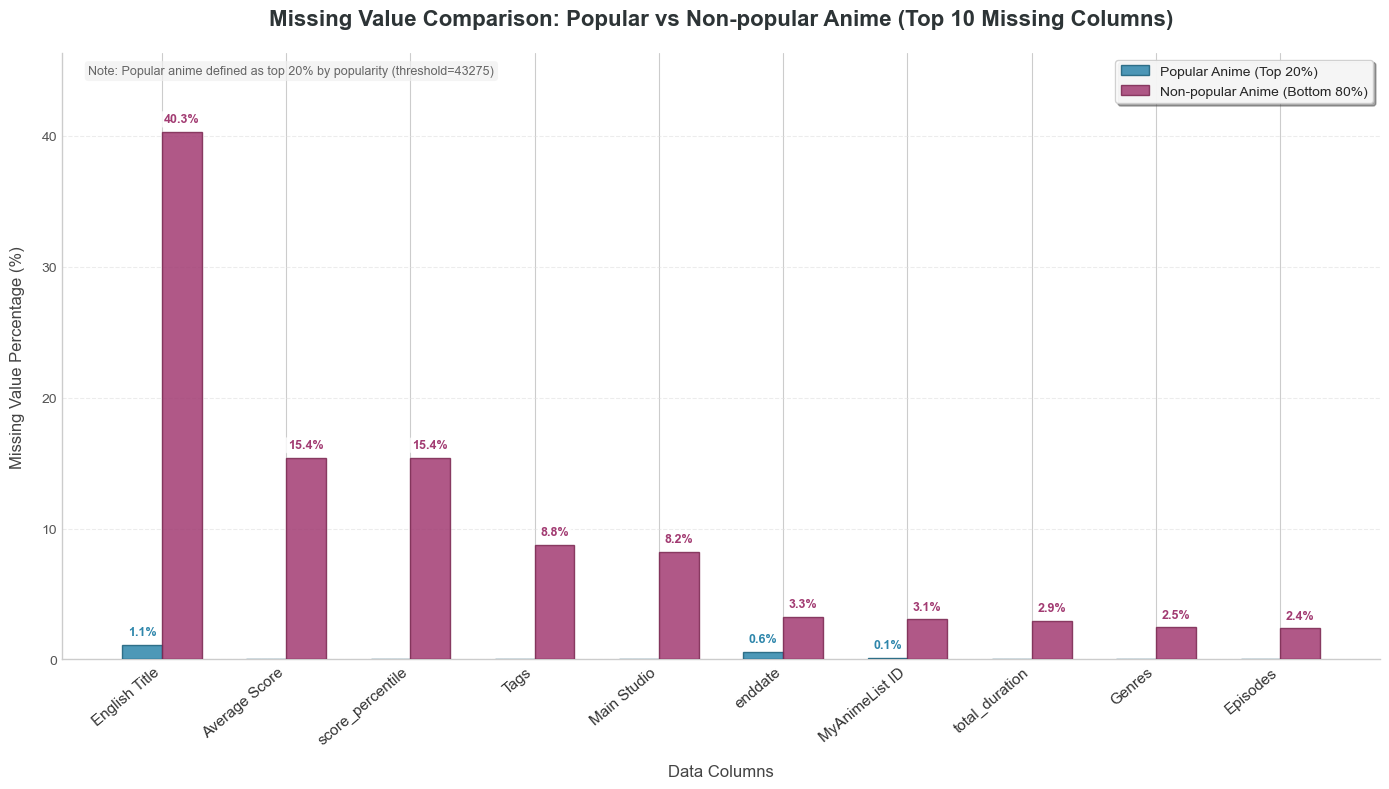


NUMERICAL COMPARISON: POPULAR VS NON-POPULAR ANIME

Top 10 Columns with Largest Missing Value Differences:
          Column  Popular Missing (%)  Non-popular Missing (%)  Difference (%)
   title_english                 1.14                    40.30          -39.15
    averagescore                 0.00                    15.40          -15.40
score_percentile                 0.00                    15.40          -15.40
            tags                 0.00                     8.77           -8.77
      mainstudio                 0.00                     8.23           -8.23
           idmal                 0.11                     3.06           -2.94
  total_duration                 0.00                     2.94           -2.94
         enddate                 0.57                     3.26           -2.69
          genres                 0.00                     2.46           -2.46
        episodes                 0.00                     2.40           -2.40

🔍 KEY INSIGHTS:
------

In [18]:
print("Performing advanced missing value analysis with popularity correlation...")

# Load the cleaned historical data for analysis
df_analysis = pd.read_csv(cleaned_historical_path)

# 1. Define popular anime using cleaned data
if 'popularity' in df_analysis.columns:
    # Define popular anime as top 20% by popularity
    popularity_threshold = df_analysis["popularity"].quantile(0.8)
    df_analysis["is_popular"] = df_analysis["popularity"] >= popularity_threshold
else:
    # Fallback to average score if popularity not available
    score_threshold = df_analysis["averagescore"].quantile(0.8)
    df_analysis["is_popular"] = df_analysis["averagescore"] >= score_threshold
    print("Using average score as popularity proxy")

# 2. Calculate missing values by popularity group
popular_df = df_analysis[df_analysis["is_popular"] == True]
non_popular_df = df_analysis[df_analysis["is_popular"] == False]

popular_missing_percent = (popular_df.isnull().sum() / len(popular_df)) * 100
non_popular_missing_percent = (non_popular_df.isnull().sum() / len(non_popular_df)) * 100

print(f"Popular anime (top 20%): {len(popular_df)} entries")
print(f"Non-popular anime: {len(non_popular_df)} entries")

# 3. Filter columns with missing values and select top 10
missing_cols = df_analysis.isnull().sum()[df_analysis.isnull().sum() > 0].index
overall_missing = (df_analysis.isnull().sum() / len(df_analysis)) * 100
top10_cols = overall_missing[missing_cols].sort_values(ascending=False).head(10).index

# 4. Prepare visualization data
x = np.arange(len(top10_cols))
width = 0.32  # Bar width
colors = ["#2E86AB", "#A23B72"]  # Professional color scheme

# 5. Create figure with appropriate size and resolution
fig, ax = plt.subplots(figsize=(14, 8), dpi=100)

# Draw bar chart with enhanced styling
bar1 = ax.bar(
    x - width/2, 
    popular_missing_percent[top10_cols], 
    width, 
    label="Popular Anime (Top 20%)", 
    color=colors[0], 
    alpha=0.85,
    edgecolor="#1A5F7A",
    linewidth=1,
    zorder=3
)
bar2 = ax.bar(
    x + width/2, 
    non_popular_missing_percent[top10_cols], 
    width, 
    label="Non-popular Anime (Bottom 80%)", 
    color=colors[1], 
    alpha=0.85,
    edgecolor="#7A2650",
    linewidth=1,
    zorder=3
)

# 6. Optimize axes and grid
ax.set_ylim(0, max(popular_missing_percent[top10_cols].max(), non_popular_missing_percent[top10_cols].max()) * 1.15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_color("#cccccc")
ax.spines["bottom"].set_color("#cccccc")

# Add horizontal grid only
ax.grid(axis="y", color="#e0e0e0", linestyle="--", alpha=0.6, zorder=0)
ax.set_axisbelow(True)

# 7. Optimize ticks and labels
ax.set_xticks(x)

# Map column names to readable labels for display
column_labels = {
    'title_english': 'English Title',
    'averagescore': 'Average Score',
    'tags': 'Tags',
    'mainstudio': 'Main Studio',
    'idmal': 'MyAnimeList ID',
    'genres': 'Genres',
    'episodes': 'Episodes',
    'source': 'Source',
    'duration': 'Duration',
    'title_native': 'Native Title',
    'meanscore': 'Mean Score',
    'startdate': 'Start Date',
    'trending': 'Trending Score',
    'favourites': 'Favorites Count'
}

xtick_labels = [column_labels.get(col, col) for col in top10_cols]

ax.set_xticklabels(
    xtick_labels, 
    rotation=40, 
    ha="right", 
    fontsize=11, 
    color="#333333"
)
ax.tick_params(axis="y", labelsize=10, colors="#555555")
ax.tick_params(axis="x", length=0)

# 8. Add value labels with background boxes
for bar in bar1:
    height = bar.get_height()
    if height > 0:
        ax.text(
            bar.get_x() + bar.get_width()/2, 
            height + 0.5, 
            f"{height:.1f}%", 
            ha="center", 
            va="bottom", 
            fontsize=9,
            color=colors[0],
            fontweight="bold",
            bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8, edgecolor="none")
        )
for bar in bar2:
    height = bar.get_height()
    if height > 0:
        ax.text(
            bar.get_x() + bar.get_width()/2, 
            height + 0.5, 
            f"{height:.1f}%", 
            ha="center", 
            va="bottom", 
            fontsize=9,
            color=colors[1],
            fontweight="bold",
            bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8, edgecolor="none")
        )

# 9. Add title and axis labels
ax.set_title(
    "Missing Value Comparison: Popular vs Non-popular Anime (Top 10 Missing Columns)", 
    fontsize=16, 
    fontweight="bold", 
    pad=20,
    color="#2d3436"
)
ax.set_xlabel(
    "Data Columns", 
    fontsize=12, 
    labelpad=12, 
    color="#444444"
)
ax.set_ylabel(
    "Missing Value Percentage (%)", 
    fontsize=12, 
    labelpad=12, 
    color="#444444"
)

# 10. Optimize legend
legend = ax.legend(
    loc="upper right",
    frameon=True,
    fancybox=True,
    shadow=True,
    framealpha=0.9,
    fontsize=10
)
legend.get_frame().set_facecolor("white")

# 11. Add annotation explaining popular definition
if 'popularity' in df_analysis.columns:
    annotation_text = f"Note: Popular anime defined as top 20% by popularity (threshold={popularity_threshold:.0f})"
else:
    annotation_text = f"Note: Popular anime defined as top 20% by average score (threshold={score_threshold:.1f})"

ax.text(
    0.02, 0.98, 
    annotation_text, 
    transform=ax.transAxes, 
    fontsize=9, 
    color="#666666",
    va="top",
    bbox=dict(boxstyle="round,pad=0.3", facecolor="#f0f0f0", alpha=0.7, edgecolor="none")
)

# Adjust layout and save
plt.tight_layout()

# Save to cleaned directory
output_image_path = os.path.join(cleaned_dir, "missing_value_popular_comparison.png")
plt.savefig(output_image_path, dpi=300, bbox_inches="tight", facecolor="#f8f9fa")
print(f"📊 Visualization saved to: {output_image_path}")
plt.show()

# 12. Output numerical comparison table with formatting
print("\n" + "="*60)
print("NUMERICAL COMPARISON: POPULAR VS NON-POPULAR ANIME")
print("="*60)

comparison_df = pd.DataFrame({
    "Column": top10_cols,
    "Popular Missing (%)": popular_missing_percent[top10_cols].round(2),
    "Non-popular Missing (%)": non_popular_missing_percent[top10_cols].round(2),
    "Difference (%)": (popular_missing_percent[top10_cols] - non_popular_missing_percent[top10_cols]).round(2)
})

# Sort by absolute difference for better insights
comparison_df["Abs Difference"] = comparison_df["Difference (%)"].abs()
comparison_df = comparison_df.sort_values("Abs Difference", ascending=False)

print("\nTop 10 Columns with Largest Missing Value Differences:")
print(comparison_df.drop(columns=["Abs Difference"]).to_string(index=False))

# Highlight key insights
print("\n🔍 KEY INSIGHTS:")
print("-" * 40)

# Find columns where popular anime have significantly more missing values
more_missing_in_popular = comparison_df[comparison_df["Difference (%)"] > 5]
if len(more_missing_in_popular) > 0:
    print("Popular anime have MORE missing values in:")
    for _, row in more_missing_in_popular.iterrows():
        print(f"  - {column_labels.get(row['Column'], row['Column'])}: +{row['Difference (%)']:.1f}%")

# Find columns where non-popular anime have significantly more missing values
more_missing_in_non_popular = comparison_df[comparison_df["Difference (%)"] < -5]
if len(more_missing_in_non_popular) > 0:
    print("\nNon-popular anime have MORE missing values in:")
    for _, row in more_missing_in_non_popular.iterrows():
        print(f"  - {column_labels.get(row['Column'], row['Column'])}: {row['Difference (%)']:.1f}%")

# Calculate overall statistics
total_popular_missing = popular_df.isnull().sum().sum()
total_non_popular_missing = non_popular_df.isnull().sum().sum()
avg_missing_per_popular = total_popular_missing / len(popular_df)
avg_missing_per_non_popular = total_non_popular_missing / len(non_popular_df)

print(f"\n📊 Overall Statistics:")
print(f"Average missing values per popular anime: {avg_missing_per_popular:.1f}")
print(f"Average missing values per non-popular anime: {avg_missing_per_non_popular:.1f}")
print(f"Relative difference: {(avg_missing_per_popular - avg_missing_per_non_popular)/avg_missing_per_non_popular*100:.1f}%")

#### Cell 7: Data Statistics After Cleaning

In [19]:
print("=" * 60)
print("DATA STATISTICS AFTER CLEANING")
print("=" * 60)

print("\nHISTORICAL DATASET KEY STATISTICS:")
print("-" * 40)

# Basic statistics
print(f"Average score: {df_hist['averagescore'].mean():.1f} ± {df_hist['averagescore'].std():.1f}")
print(f"Average popularity: {df_hist['popularity'].mean():.0f} ± {df_hist['popularity'].std():.0f}")
print(f"Average episodes: {df_hist['episodes'].mean():.1f} ± {df_hist['episodes'].std():.1f}")

# Sequel analysis
if 'is_sequel' in df_hist.columns:
    sequel_count = df_hist['is_sequel'].sum()
    print(f"Number of sequels: {sequel_count} ({sequel_count/len(df_hist)*100:.1f}%)")

# Studio analysis
if 'is_big_studio' in df_hist.columns:
    big_studio_count = df_hist['is_big_studio'].sum()
    print(f"Produced by big studios: {big_studio_count} ({big_studio_count/len(df_hist)*100:.1f}%)")

# Genre analysis
if 'genre_count' in df_hist.columns:
    print(f"Average genres per anime: {df_hist['genre_count'].mean():.1f} ± {df_hist['genre_count'].std():.1f}")

print("\n" + "=" * 60)
print("\nWINTER 2026 DATASET KEY STATISTICS:")
print("-" * 40)

# Get score column name
score_col = 'average_score' if 'average_score' in df_new.columns else 'averagescore'
if score_col in df_new.columns:
    print(f"Average score: {df_new[score_col].mean():.1f} ± {df_new[score_col].std():.1f}")

# Get popularity column name
pop_col = 'popularity' if 'popularity' in df_new.columns else None
if pop_col in df_new.columns:
    print(f"Average popularity: {df_new[pop_col].mean():.0f} ± {df_new[pop_col].std():.0f}")

if 'episodes' in df_new.columns:
    print(f"Average episodes: {df_new['episodes'].mean():.1f} ± {df_new['episodes'].std():.1f}")

# Sequel analysis for 2026
if 'is_sequel' in df_new.columns:
    sequel_count = df_new['is_sequel'].sum()
    print(f"Number of sequels: {sequel_count} ({sequel_count/len(df_new)*100:.1f}%)")

# Studio analysis for 2026
if 'is_big_studio' in df_new.columns:
    big_studio_count = df_new['is_big_studio'].sum()
    print(f"Produced by big studios: {big_studio_count} ({big_studio_count/len(df_new)*100:.1f}%)")

# Genre analysis for 2026
if 'genre_count' in df_new.columns:
    print(f"Average genres per anime: {df_new['genre_count'].mean():.1f} ± {df_new['genre_count'].std():.1f}")

print("\n" + "=" * 60)
print("\nCLEANING PROCESS COMPLETED SUCCESSFULLY!")
print(f"Cleaned files saved to:")
print(f"  Historical: {cleaned_historical_path}")
print(f"  Winter 2026: {cleaned_winter_2026_path}")

DATA STATISTICS AFTER CLEANING

HISTORICAL DATASET KEY STATISTICS:
----------------------------------------
Average score: 64.7 ± 10.9
Average popularity: 32075 ± 68828
Average episodes: 11.2 ± 18.1
Number of sequels: 1007 (23.0%)
Produced by big studios: 635 (14.5%)
Average genres per anime: 2.6 ± 1.3


WINTER 2026 DATASET KEY STATISTICS:
----------------------------------------
Average score: nan ± nan
Average popularity: 7543 ± 14848
Average episodes: 2.8 ± 4.9
Number of sequels: 18 (21.7%)
Produced by big studios: 7 (8.4%)
Average genres per anime: 2.7 ± 1.5


CLEANING PROCESS COMPLETED SUCCESSFULLY!
Cleaned files saved to:
  Historical: f:\Data Science\data-science-programing\Final Project Notebook\../DataAnalysisPart/animation_data/cleaned/anilist_anime_2016_2025_cleaned.csv
  Winter 2026: f:\Data Science\data-science-programing\Final Project Notebook\../DataAnalysisPart/animation_data/cleaned/anime_winter_2026_cleaned.csv


## 3.3 Data Management
#### 3.3.1 Clear Folder/Data Organization
A hierarchical directory structure was adopted to manage the full dataset, ensuring traceability of data flow:
```
./animation_data/
├── raw/                      # Raw data (uncleaned)
│   ├── anilist_anime_2016_2025_raw.csv
│   └── anime_winter_2026_raw.csv
├── cleaned/                  # Standardized data after cleaning
│   ├── anilist_anime_2016_2025_cleaned.csv
│   └── anime_winter_2026_cleaned.csv
```
All data files follow the naming convention of `[data_source]_[data_scope]_[processing_status].csv`, facilitating quick localization and version differentiation.

#### 3.3.2 Ensuring Reproducibility of Results
The reproducibility of data cleaning and engineering results was ensured by fixing data processing functions and workflows (column name standardization, text cleaning, feature derivation logic); the final exported cleaned data files contain no index (`index=False`), guaranteeing consistency in data structure.

# 4. Data Analysis: Learning, Analytics, Visualization
This section documents our data analysis process and the creation of an interactive dashboard that clearly demonstrates our project motivation and findings. We have developed a dashboard for presenting data analysis results, as well as a search interface for querying and displaying information such as anime popularity, as illustrated in Figure 1.

<div align="center">
    <img src="images/dashboard_search.png" width="80%" alt="Figure 1: Anime Discover Page">
    <p style="text-align:center; color:#666; font-size:20px;">Figure 1: Anime Discover Page</p>
</div>

#### Preprocess Anime Dataframe

In [ ]:
def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = (
        df.columns.str.strip()
                    .str.lower()
                    .str.replace(" ", "_")
                    .str.replace("(", "")
                    .str.replace(")", "")
                    .str.replace("-", "_")
    )
    return df


def clean_text(x):
    if pd.isna(x):
        return x
    x = str(x)
    return (
        x.replace("\n", " ")
            .replace("<i>", "")
            .replace("</i>", "")
            .replace("<br>", " ")
            .strip()
    )


def parse_genres(x):
    if pd.isna(x):
        return []
    return [g.strip() for g in str(x).split(",") if g.strip()]


def preprocess_anime_df(df: pd.DataFrame, write_cleaned_path: str = None) -> pd.DataFrame:
    """
    Perform unified column naming, text cleaning, standardization of numeric and date fields, 
    genre parsing, and calculation of derived fields on the input DataFrame.

    :param df: Raw DataFrame
    :param write_cleaned_path: If provided, write the cleaned DataFrame to a CSV file (optional)
    :return: DataFrame after cleaning and derived field calculation
    """
    if not isinstance(df, pd.DataFrame):
        raise TypeError("df must be a pandas.DataFrame")

    df_hist = normalize_columns(df)

    # Text field cleaning
    for col in ["title_romaji", "title_english", "title_native", "description"]:
        if col in df_hist.columns:
            df_hist[col] = df_hist[col].apply(clean_text)

    # Numeric field processing
    num_cols = ["id", "idmal", "episodes", "duration", "averagescore",
                "meanscore", "favourites", "popularity"]
    for col in num_cols:
        if col in df_hist.columns:
            df_hist[col] = pd.to_numeric(df_hist[col], errors="coerce")

    # Date field format standardization
    for col in ["startdate", "enddate"]:
        if col in df_hist.columns:
            df_hist[col] = pd.to_datetime(df_hist[col], errors="coerce")

    # Genres parsing
    if "genres" in df_hist.columns:
        df_hist["genres"] = df_hist["genres"].apply(parse_genres)

    # Check if the anime is a sequel
    if "title_romaji" in df_hist.columns:
        df_hist["is_sequel"] = df_hist["title_romaji"].str.contains(
            "Season|2nd|3rd|II|III|IV|V|VI",
            case=False, na=False
        )
    else:
        df_hist["is_sequel"] = False

    # Number of genres
    if "genres" in df_hist.columns:
        df_hist["genre_count"] = df_hist["genres"].apply(len)
    else:
        df_hist["genre_count"] = 0

    # Total content duration (episodes * duration per episode)
    if "episodes" in df_hist.columns and "duration" in df_hist.columns:
        df_hist["total_duration"] = df_hist["episodes"] * df_hist["duration"]

    # Release year
    if "startdate" in df_hist.columns:
        df_hist["start_year"] = df_hist["startdate"].dt.year

    # Classify major production studios (case-insensitive matching)
    big_studios = ["MAPPA", "ufotable", "Bones", "CloverWorks", "A-1 Pictures",
                    "Kyoto Animation", "WIT Studio", "MADHOUSE"]
    big_upper = [s.upper() for s in big_studios]
    if "mainstudio" in df_hist.columns:
        df_hist["is_big_studio"] = df_hist["mainstudio"].fillna("").astype(str).str.upper().isin(big_upper)
    else:
        df_hist["is_big_studio"] = False

    if write_cleaned_path:
        try:
            df_hist.to_csv(write_cleaned_path, index=False)
        except Exception:
            # Do not block the main process, only log to Streamlit (if called in a Streamlit page)
            try:
                st.warning(f"Failed to write cleaned file to {write_cleaned_path}")
            except Exception:
                pass

    return df_hist

## 4.1 Dashboard Implementation and Overview
This platform provides a series of visualizations designed to explore various aspects of anime data in depth, including trends across different genres, platforms, and studios.

Through this dashboard, users can explore key patterns, relationships, and trends within the anime industry, experiencing clear and intuitive interactive data exploration.

### 4.1.1 Anime Overview Visualization

This section provides a macro-level view of the dataset, displaying key trends and statistical data based on different parameters.

- **Core Overview**: Presents the basic composition and distribution characteristics of the anime dataset from a global perspective.


In [ ]:
def plot_anime_visualizations(anime_df):
    """
    Plot anime data visualizations
    :param anime_df: Dataset obtained from data_manager
    """
    # Data Processing: Extract and remove missing values from the "format" column
    visual_data = anime_df[["format"]].dropna()

    # Count the number of different anime formats and convert to native data types
    type_counts = visual_data["format"].value_counts()
    type_list = type_counts.index.tolist()  # Get list of anime formats
    count_list = type_counts.values.tolist()  # Get corresponding count list

    # ========== 1. Pie Chart: Distribution of Different Anime Formats ==========

    # This chart displays the proportion of different anime formats
    # Data Processing: Count format frequencies via value_counts and convert to ECharts-compatible format
    pie_data = [{"name": t, "value": v} for t, v in type_counts.items()]
    pie_options = {
        "tooltip": {"trigger": "item"},  # Show detailed information on mouse hover
        "series": [
            {
                "name": "Anime Type",
                "type": "pie",
                "radius": ["40%", "70%"],  # Set as a donut chart (more visually appealing)
                "data": pie_data,
                "label": {"show": True, "formatter": "{b}: {c} ({d}%)"},  # Show labels and percentages
            }
        ],
        "color": ["#FF6B6B", "#4ECDC4", "#45B7D1", "#96CEB4", "#FFEAA7"],  # Color scheme
    }
    st_echarts(options=pie_options, height="400px", key='distribution of different types by pie')

    # ========== 2. Bar Chart: Comparison of Different Anime Formats ==========

    # This chart shows the quantitative comparison of different anime formats
    # Data Processing: Count quantities using value_counts and generate format suitable for bar charts
    bar_options = {
        "tooltip": {"trigger": "axis", "axisPointer": {"type": "shadow"}},
        "xAxis": {
            "type": "category",
            "data": type_list,
            "axisLabel": {
                "interval": 0  # Force display of all labels
            }
        },
        "yAxis": {"type": "value", "name": "Count"},
        "series": [{
            "name": "Anime Count",
            "type": "bar",
            "data": count_list,
            "color": ["#4ECDC4"],
            "label": {
                "show": True,  # Show values on the bar chart
                "position": "top",  # Display above the bars
                "formatter": "{c}",  # Show numerical values
                "fontSize": 12,  # Font size of values
                "color": "#333"  # Font color of values
            }
        }],
        "grid": {"left": "3%", "right": "3%", "bottom": "20%", "containLabel": True}
    }
    st_echarts(options=bar_options, height="400px", key='distribution of different types by bar')


<div align="center">
    <img src="images/overview_sta.png" width="40%" alt="Figure 2: Anime Overview Visualization">
    <p style="text-align:center; color:#666; font-size:20px;">Figure 2: Anime Overview Visualization</p>
</div>

This visualization shows anime type distribution: TV dominates with 1,697 entries (38.8%), followed by ONA (932, 21.31%) and MOVIE (667, 15.25%). Smaller categories include TV_SHORT (504, 11.52%), SPECIAL (300, 6.86%), OVA (268, 6.12%), and MUSIC (6, 0.14%). The pie chart illustrates proportions, while the bar chart clearly displays exact counts, highlighting TV as the most common anime format.

### 4.1.2. Genre Analysis

This section delves into the distribution of anime genres, revealing the most popular genres within the dataset.

- **Popularity & Score Analysis by Genre (Top 10)**: Compares and analyzes the average popularity and average scores of the top ten genres through forms such as dual-axis charts.


In [ ]:
def plot_genre_analysis(anime_df):
    """Analyze average popularity and average score for each Genre (vertical chart + Top10 + lowercase column adaptation)"""
    st.subheader("Analysis of Popularity & Score by Anime Genre (Top 10)")

    # Data Preprocessing: Remove missing values and split the "genres" column to generate rows for each genre
    df = anime_df[["genres", "popularity", "averageScore"]].dropna()
    df["genres"] = df["genres"].str.split("|")
    df_exploded = df.explode("genres").reset_index(drop=True)
    df_exploded = df_exploded[df_exploded["genres"] != ""].reset_index(drop=True)

    if len(df_exploded) == 0:
        st.warning("No valid Genre data!")
        return

    # Sort by average popularity and select the top 10 anime genres
    genre_stats = df_exploded.groupby("genres").agg({
        "popularity": "mean",  # Calculate average popularity for each genre
        "averageScore": "mean"  # Calculate average score for each genre
    }).reset_index()
    genre_stats = genre_stats.sort_values("popularity", ascending=False).head(10)

    # Data Conversion: Transform data into a format suitable for plotting
    genre_list = genre_stats["genres"].tolist()
    avg_popularity = genre_stats["popularity"].astype(int).tolist()
    avg_score = genre_stats["averageScore"].round(2).tolist()

    # ========== 3. Dual-Axis Vertical Chart Configuration (Resolve X-axis Text Occlusion) ==========

    options = {
        "tooltip": {
            "trigger": "axis",
            "axisPointer": {"type": "shadow"}
        },
        "legend": {
            "data": ["Average Popularity", "Average Score"],
            "top": 0
        },
        "grid": {
            "left": "3%",
            "right": "10%",
            "bottom": "40%",  # Adjust bottom space to avoid X-axis text overlap
            "containLabel": True
        },
        "xAxis": [
            {
                "type": "category",
                "data": genre_list,
                "axisLabel": {
                    "interval": 0,  # Force display of all labels
                    "rotate": -30,  # Rotate text to avoid overlap
                    "align": "center",  # Center-align text
                    "margin": 30,  # Increase spacing between text and X-axis
                    "overflow": "break"  # Auto-wrap long text
                }
            }
        ],
        "yAxis": [
            {
                "type": "value",
                "name": "Average Popularity",
                "min": 0,
                "axisLabel": {"formatter": "{value}"}
            },
            {
                "type": "value",
                "name": "Average Score",
                "min": 50,
                "max": 100,
                "axisLabel": {"formatter": "{value} pts"},
                "position": "right",
                "offset": 0
            }
        ],
        "series": [
            {
                "name": "Average Popularity",
                "type": "bar",
                "data": avg_popularity,
                "itemStyle": {"color": "#4ECDC4"},
                "label": {"show": True, "position": "top", "formatter": "{c}"}
            },
            {
                "name": "Average Score",
                "type": "line",
                "yAxisIndex": 1,
                "data": avg_score,
                "itemStyle": {"color": "#FF6B6B"},
                "symbol": "circle",
                "label": {"show": True, "position": "bottom", "formatter": "{c}"}
            }
        ]
    }
    st_echarts(options=options, height="600px", key='distribution of different types')

    st.subheader("Top 10 Popular Genres Details")
    st.dataframe(
        genre_stats.rename(columns={
            "genres": "Anime Genre",
            "popularity": "Average Popularity",
            "averageScore": "Average Score"
        }),
        use_container_width=True
    )


<div align="center">
    <img src="images/genre%20analysis.png" width="50%" alt="Figure 3: Anime Genre Analysis">
    <p style="text-align:center; color:#666; font-size:20px;">Figure 3: Anime Genre Analysis</p>
</div>




- **Top 10 Popular Genres Details**: Provides an interactive table showcasing detailed statistical data for leading genres, such as the number of works, average score, average popularity, etc.



<div align="center">

| Average Popularity | Anime Genre   | Average Score |
|--------------------|---------------|---------------|
| 110575.81          | Psychological | 72.94         |
| 88921.37           | Supernatural  | 69.37         |
| 85708.70           | Thriller      | 67.82         |
| 79071.12           | Drama         | 71.14         |
| 78299.17           | Romance       | 70.24         |
| 77911.70           | Horror        | 66.36         |
| 76265.24           | Mystery       | 69.26         |
| 72471.35           | Psychological | 69.45         |
| 70413.95           | Adventure     | 67.82         |
| 62664.85           | Supernatural  | 68.36         |

*Average Popularity and Score by Anime Genre
</div>


### 4.1.3. Studio and Platform Partnership Analysis

This section focuses on analyzing the collaborative relationships between anime production studios and streaming platforms, highlighting the key cooperation networks that drive industry trends.

- **Partnership Network**: Visualizes the frequency and intensity of collaboration between studios and platforms through heatmaps or Sankey diagrams.
- **Top 10 Studios and Streaming Platform Partnerships**: Focuses on leading studios, specifically displaying their main collaborations with various platforms, revealing different collaboration strategies and market positioning.


In [ ]:
# Cleaning function to retrieve streaming platform information: 
# 1. First, remove invalid strings (e.g., null values), then parse JSON via the "site" field to extract platform names.
# 2. Successively count the number of collaborations between the top 10 studios and streaming platforms, and generate a heatmap

#### Cell 1: Remove invalid strings

In [ ]:
def clean_external_links(external_links_json):
    """Clean and extract valid streaming platform information"""
    if isinstance(external_links_json, str):
        try:
            clean_json = external_links_json.strip()
            clean_json = clean_json.replace('NaN', 'null')  
            links = json.loads(clean_json)  # Convert to JSON
            platforms = [link['site'] for link in links if 'site' in link]
            return platforms
        except (json.JSONDecodeError, TypeError):
            return []  # Return an empty list if unable to parse
    return []  # Return an empty list if not a valid string

#### Cell 2: Generate a heatmap to analysis platform partnership

In [ ]:
def plot_studio_platform_partnerships(anime_df):
    """Display top 10 studios and their streaming platform partnerships"""
    st.subheader("Top 10 Studios and Streaming Platform Partnerships")

    # Get top 10 studios by anime production count
    top_10_studios = anime_df['mainStudio'].value_counts().head(10).index.tolist()
    
    # Create data structure to store partnerships
    studio_platform_data = []

    # Count collaborations between studios and streaming platforms
    for studio in top_10_studios:
        studio_data = anime_df[anime_df['mainStudio'] == studio]
        
        # Extract streaming platforms for each anime (one anime can have multiple platforms)
        for _, row in studio_data.iterrows():
            ## Clean and extract streaming platform information
            platforms = clean_external_links(row['externalLinksJson'])
            for platform in platforms:
                studio_platform_data.append((studio, platform))

    # Create DataFrame for platform counts
    studio_platform_counts = pd.DataFrame(studio_platform_data, columns=['studio', 'platform'])
    platform_counts = studio_platform_counts.groupby(['studio', 'platform']).size().reset_index(name='count')

    # Create pivot table to use for heatmap
    heatmap_data = platform_counts.pivot(index="studio", columns="platform", values="count").fillna(0)

    # Plot interactive heatmap using Plotly
    fig = px.imshow(
        heatmap_data,
        labels={'x': 'Platform', 'y': 'Studio', 'color': 'Partnership Count'},
        color_continuous_scale='YlGnBu',
        title="Heatmap of Studio and Streaming Platform Partnerships",
        aspect="auto"
    )

    fig.update_layout(
        xaxis={'side': 'top', 'tickangle': 45},
        yaxis={'showgrid': False},
        title_x=0.5,
        title_y=0.95,
        width=1000,  # Adjust width and height for better fit
        height=600
    )

    # Display the interactive Plotly heatmap
    st.plotly_chart(fig)


<div align="center">
    <img src="images/heatmap.png" width="60%" alt="Figure 4: Top 10 Studios and Streaming Platform Partnerships">
    <p style="text-align:center; color:#666; font-size:20px;">Figure 4: Top 10 Studios and Streaming Platform Partnerships</p>
</div>

These visualizations provide valuable insights into anime trends and can effectively guide your analysis. Feel free to interact with the charts, adjust filters, and delve deeper into the data.

## 4.2 Popularity Factor Analysis

#### Motivation
Production and investment decisions in the anime industry depend heavily on identifying "popular elements." Many small production teams fail to produce successful works due to poor feature selection or misguided production direction.

This analysis aims to **quantify which characteristics determine anime popularity**, providing practical decision-making insights for producers and investors by:
- Identifying core features (formats, source materials, genres) with high popularity probability
- Flagging low-return creative directions (niche formats, unpopular source materials)

#### Analysis Framework
We analyze seven key feature dimensions that influence popularity: Format, Source Material, Genres, Animation Studios, Episode Count, Episode Duration, and Score.

The analysis follows a **comparative methodology**: anime are divided into "high-popularity" (top 20% by popularity) and "normal" groups, then feature distributions are compared between these groups.

### 4.2.1 Format vs Popularity Analysis

#### Objective
To investigate the relationship between anime formats (TV series, OVA, movies, etc.) and popularity. By analyzing high-popularity rates and average popularity across formats, determine which format is most likely to achieve popularity.

#### Visualization
- **Dual-Axis Chart**: Combines high-popularity ratio (bars) with average popularity (line)
- **Key Metric**: High popularity ratio percentage for each format


In [20]:
import streamlit as st
from streamlit_echarts import st_echarts

2025-12-11 20:42:18.262 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [21]:
def format_popularity_analysis(df):
    # ========== Analysis 1: Impact of Anime Format on Popularity ==========
    st.subheader("1. Anime Format vs Popularity")
    # Statistics on "high popularity ratio" and "average popularity" for each format
    format_stats = df.groupby("format").agg({
        "is_high_pop": ["count", "mean"],  # count=total in format, mean=high popularity ratio (0-1)
        "popularity": "mean"  # average popularity for the format
    }).round(3)
    format_stats.columns = ["Total Count", "High Popularity Ratio", "Average Popularity"]
    format_stats = format_stats.sort_values("High Popularity Ratio", ascending=False)

    # Visualization: dual-axis chart (high popularity ratio + average popularity)
    format_list = format_stats.index.tolist()
    high_pop_ratio = (format_stats["High Popularity Ratio"] * 100).tolist()  # Convert to percentage
    avg_popularity = format_stats["Average Popularity"].astype(int).tolist()

    format_options = {
        "tooltip": {"trigger": "axis"},
        "legend": {"data": ["High Popularity Ratio(%)", "Average Popularity"]},
        "grid": {"bottom": "20%"},
        "xAxis": {"type": "category", "data": format_list, "axisLabel": {"rotate": -45}},
        "yAxis": [
            {"type": "value", "name": "High Popularity Ratio(%)", "max": 100},
            {"type": "value", "name": "Average Popularity", "position": "right"}
        ],
        "series": [
            {"name": "High Popularity Ratio(%)", "type": "bar", "data": high_pop_ratio, "color": "#FF6B6B"},
            {"name": "Average Popularity", "type": "line", "yAxisIndex": 1, "data": avg_popularity, "color": "#4ECDC4"}
        ]
    }
    st_echarts(options=format_options, height="400px")


<div align="center">
    <img src="images/Anime Format vs Popularity.png" width="60%" alt="Figure 5: Relationship between Anime Format and Popularity">
    <p style="text-align:center; color:#666; font-size:20px;">Figure 5: Relationship between Anime Format and Popularity</p>
</div>



#### Key Finding
TV format dominates with the highest high-popularity ratio (41.2%) and highest average popularity, far exceeding other formats. Movie format ranks second but with significant performance gap (~20% high-popularity ratio).

#### Analytical Reasoning
Different formats correspond to distinct production models and audience expectations:
- **TV Format**: Benefits from fixed weekly updates building sustained engagement, broad accessibility via streaming/TV networks, and flexible storytelling length
- **Movie Format**: Relies on high production values but has limited exposure due to theatrical release constraints
- **Niche Formats**: OVA/ONA target dedicated fanbases with shorter/irregular releases, limiting mainstream reach


### 4.2.2 Source Material vs Popularity Analysis

#### Objective
Analyze the influence of anime source materials (manga, novels, original works, etc.) on popularity. Compare high-popularity rates across different sources to identify which original basis is most likely to produce popular anime.

#### Visualization
- **Bar Chart**: High-popularity ratio percentage for each source material
- **Sorting**: Results sorted by descending high-popularity ratio

In [ ]:
def source_popularity_analysis(df):
    # ========== Analysis 2: Impact of Source Material on Popularity ==========
    st.subheader("2. Source Material vs Popularity")
    source_df = df.dropna(subset=["source"])

    # Statistics on high popularity ratio for each source
    source_stats = source_df.groupby("source").agg({
        "is_high_pop": "mean",
        "popularity": "mean"
    }).round(3)
    source_stats.columns = ["High Popularity Ratio", "Average Popularity"]
    source_stats = source_stats.sort_values("High Popularity Ratio", ascending=False)

    # Visualization: bar chart (high popularity ratio)
    source_options = {
        "tooltip": {"trigger": "axis", "formatter": "{b}: {c}%"},
        "xAxis": {"type": "category", "data": source_stats.index.tolist(), "axisLabel": {"rotate": -45}},
        "yAxis": {"type": "value", "name": "High Popularity Ratio(%)", "max": 100},
        "series": [{"name": "High Popularity Ratio(%)", "type": "bar",
                    "data": (source_stats["High Popularity Ratio"] * 100).tolist(),
                    "color": "#9B59B6"}]
    }
    st_echarts(options=source_options, height="400px", key='differ source by bar')


<div align="center">
    <img src="images/Analysis of the original work type and popularity.png" width="60%" alt="Figure 6: Analysis of the original work type and popularity">
    <p style="text-align:center; color:#666; font-size:20px;">Figure 6: Relationship between the Original Work Type and Popularity</p>
</div>


#### Key Finding
Anime adapted from LIGHT_NOVEL has the highest high-popularity ratio (50.4%), followed by MANGA. Original works and Video Game adaptations show much lower success rates.

#### Analytical Reasoning
Source materials differ in fan base and adaptation potential:
- **Light Novels**: Rich world-building, detailed characters, dedicated fan base, text-based storytelling allows flexible animation adaptation
- **Manga**: Pre-existing visual storyboards lower adaptation costs, established broad readership
- **Original Works**: Lack pre-existing fan base, require building story/worldview from scratch
- **Video Games**: Face challenges adapting fragmented game plots to linear animation

Analysis of the original work type and popularity

### 4.2.3 Genres vs Popularity Analysis

#### Objective
Compare genre distribution differences between popular and ordinary anime. Identify genres significantly overrepresented in the high-popularity group, clarifying which genres are core elements of popular anime.

#### Visualization
- **Dual Bar Chart**: Side-by-side comparison of genre proportions in high-popularity vs normal groups
- **Top 15 Genres**: Focus on most common genres in dataset


In [ ]:
def genres_popularity_analysis(df, high_pop_df, normal_pop_df):
    # ========== 4. Analysis 3: Impact of Anime Genres on Popularity ==========
    df = df.dropna(subset=["genres"])
    high_pop_df = high_pop_df.dropna(subset=["genres"]) # High popularity group
    normal_pop_df = normal_pop_df.dropna(subset=["genres"]) # Normal group

    st.subheader("3. Anime Genres vs Popularity")
    # Split multiple genres and compare ratios in high popularity/normal groups
    # Genre distribution in high popularity group
    high_pop_genres = high_pop_df.explode("genres")["genres"].value_counts(normalize=True) * 100
    # Genre distribution in normal group
    normal_pop_genres = normal_pop_df.explode("genres")["genres"].value_counts(normalize=True) * 100
    # Compare top 15 common genres
    common_genres = df.explode("genres")["genres"].value_counts().head(15).index.tolist()
    genre_compare = pd.DataFrame({
        "High Popularity Group(%)": high_pop_genres[common_genres].fillna(0),
        "Normal Group(%)": normal_pop_genres[common_genres].fillna(0)
    }).round(1)

    # Visualization: dual bar chart comparison
    genre_options = {
        "tooltip": {"trigger": "axis"},
        "legend": {"data": ["High Popularity Group(%)", "Normal Group(%)"]},
        "grid": {"bottom": "25%"},
        "xAxis": {"type": "category", "data": common_genres, "axisLabel": {"rotate": -45}},
        "yAxis": {"type": "value", "name": "Genre Ratio(%)"},
        "series": [
            {"name": "High Popularity Group(%)", "type": "bar",
             "data": genre_compare["High Popularity Group(%)"].tolist(),
             "color": "#E74C3C"},
            {"name": "Normal Group(%)", "type": "bar", "data": genre_compare["Normal Group(%)"].tolist(),
             "color": "#3498DB"}
        ]
    }
    st_echarts(options=genre_options, height="500px", key='differ genres by bar')


<div align="center">
    <img src="images/genres vs popularity.png" width="60%" alt="Figure 7: Relationship between Genres and Popularity">
    <p style="text-align:center; color:#666; font-size:20px;">Figure 7: Relationship between Genres and Popularity</p>
</div>



#### Key Finding
Certain genres (Action, Fantasy, Romance) account for larger proportions in the high-popularity group, serving as core popularity drivers. Niche genres (Mecha, Sports) have lower proportions and limited mainstream appeal.

#### Analytical Reasoning
- **Popularity-Driving Genres**: Romance and Supernatural have significantly higher proportions in high-popularity group
- **Common but Not Core**: Comedy appears frequently but has higher proportion in normal group
- **Niche Genres**: Mecha, Psychological have low proportions in both groups

### 4.2.4 Animation Studios vs Popularity Analysis

#### Objective
Analyze the influence of production studios on anime popularity. Focus on major studios with substantial work volumes, calculate their high-popularity rates, and determine the correlation between studio strength and popularity achievement.

#### Visualization
- **Bar Chart**: High-popularity ratios for top 15 studios (≥20 works)
- **Studio Filtering**: Excludes niche studios with limited production volume


In [ ]:
def studios_popularity_analysis(df):
    # ========== 5. Analysis 4: Impact of Studios on Popularity ==========
    df = df.dropna(subset=["mainStudio"])

    st.subheader("4. Animation Studios vs Popularity")
    # Filter top studios with ≥20 animated works
    studio_count = df.explode("mainStudio")["mainStudio"].value_counts()
    major_studios = studio_count[studio_count >= 20].index.tolist()

    # Statistics on high popularity ratio for each studio
    studio_stats = {}
    for studio in major_studios:
        studio_anime = df[df["mainStudio"].apply(lambda x: studio in x)]
        if len(studio_anime) < 20:
            continue
        high_pop_ratio = studio_anime["is_high_pop"].mean()
        studio_stats[studio] = {
            "High Popularity Ratio": high_pop_ratio,
            "Number of Works": len(studio_anime),
            "Average Popularity": studio_anime["popularity"].mean()
        }
    
    studio_stats = pd.DataFrame(studio_stats).T.sort_values("High Popularity Ratio", ascending=False).round(3)
    top15_studios = studio_stats.head(15)  # only top 15 studios

    # Visualization
    if not top15_studios.empty: 
        studio_options = {
            "tooltip": {"trigger": "axis", "formatter": "{b}: {c}%"},
            "xAxis": {
                "type": "category",
                "data": top15_studios.index.tolist(), 
                "axisLabel": {"rotate": -45}
            },
            "yAxis": {"type": "value", "name": "High Popularity Ratio(%)", "max": 100},
            "series": [{
                "name": "High Popularity Ratio(%)",
                "type": "bar",
                "data": (top15_studios["High Popularity Ratio"] * 100).tolist(), 
                "color": "#F39C12"
            }]
        }
        st_echarts(options=studio_options, height="500px", key='different studio by bar')


<div align="center">
    <img src="images/studios vs pop.png" width="60%" alt="Figure 8: Relationship between Studios and Popularity">
    <p style="text-align:center; color:#666; font-size:20px;">Figure 8: Relationship between Studios and Popularity</p>
</div>



#### Key Finding
Among mainstream studios, diomedéa has the highest high-popularity ratio (52.4%). Top studios generally maintain significantly higher high-popularity ratios, confirming studio strength as key popularity contributor.

#### Analytical Reasoning
Top studios possess:
- Mature production teams and stable high-quality project partnerships
- Keen grasp of market-preferred content styles
- Technical expertise, industry resource access, and accumulated audience trust
- Consistent ability to deliver works aligning with viewer preferences

### 4.2.5 Episode Count Distribution Analysis

#### Objective
Analyze the impact of episode count on anime popularity by comparing distribution patterns between high-popularity and ordinary anime. Identify optimal episode range for popular works.

#### Visualization
- **Dual Pie Charts**: Side-by-side episode count distribution in high-popularity vs normal groups
- **Episode Binning**: [1-12, 13-24, 25-48, 49-100, 100+] episode ranges


In [ ]:
def episodes_popularity_analysis(high_pop_df, normal_pop_df):
    # 6.1 Comparison of episode distribution
    high_pop_df = high_pop_df[
        (high_pop_df["episodes"].notna())
        & (high_pop_df["episodes"] != 0)  # Exclude missing/zero episodes
        ]
    normal_pop_df = normal_pop_df[
        (normal_pop_df["episodes"].notna())
        & (normal_pop_df["episodes"] != 0)
        ]

    st.subheader("Comparison of Episode Distribution")
    episodes_bins = [0, 12, 24, 48, 100, float("inf")]
    episodes_labels = ["1-12 eps", "13-24 eps", "25-48 eps", "49-100 eps", "100+ eps"]
    high_pop_df["episodes_bin"] = pd.cut(high_pop_df["episodes"], bins=episodes_bins, labels=episodes_labels,
                                         right=False)
    normal_pop_df["episodes_bin"] = pd.cut(normal_pop_df["episodes"], bins=episodes_bins, labels=episodes_labels,
                                           right=False)

    episodes_stats = pd.DataFrame({
        "High Popularity Group": high_pop_df["episodes_bin"].value_counts(normalize=True) * 100,
        "Normal Group": normal_pop_df["episodes_bin"].value_counts(normalize=True) * 100
    }).fillna(0).round(1)

    episodes_options = {
        "tooltip": {"trigger": "item"},
        "legend": {
            "bottom": 0,  # Place legend at bottom to avoid blocking pie chart
            "orient": "horizontal"  # Arrange legend horizontally
        },
        "series": [
            # High popularity group pie chart: left side
            {
                "name": "High Popularity",
                "type": "pie",
                "data": [{"name": k, "value": v} for k, v in episodes_stats["High Popularity Group"].items()],
                "center": ["25%", "50%"],  # Independent position: left half
                "radius": ["30%", "60%"]  # Pie chart size
            },
            # Normal group pie chart: right side
            {
                "name": "Normal",
                "type": "pie",
                "data": [{"name": k, "value": v} for k, v in episodes_stats["Normal Group"].items()],
                "center": ["75%", "50%"],  # Independent position: right half
                "radius": ["30%", "60%"]
            }
        ]
    }
    st_echarts(options=episodes_options, height="300px", key="episodes_dist")


<div align="center">
    <img src="images/Comparison of Episode Distribution.png" width="70%" alt="Figure 9: Comparison of Episode Distribution">
    <p style="text-align:center; color:#666; font-size:20px;">Figure 9: Comparison of Episode Distribution</p>
</div>



#### Key Finding
High-popularity group dominated by anime with 13-24 episodes (seasonal length). Normal group has higher proportion of 1-12 episode works. 13-24 episodes represents optimal range for popular works.

#### Analytical Reasoning
Episode count correlates with content rhythm and audience commitment:
- **13-24 episodes**: Balances story completeness and pacing, maintains audience engagement throughout season
- **1-12 episodes**: Often lacks sufficient content depth to resonate with broad audience
- **25+ episodes**: Requires sustained high-quality storytelling, harder to maintain consistently

### 4.2.6 Episode Duration Distribution Analysis

#### Objective
Explore the relationship between episode duration and anime popularity by comparing duration distributions between high-popularity and ordinary anime. Determine preferred duration range for popular works.

#### Visualization
- **Dual Pie Charts**: Side-by-side duration distribution in high-popularity vs normal groups  
- **Duration Binning**: [≤15, 16-25, 26-45, >45] minute ranges


In [ ]:
def duration_popularity_analysis(high_pop_df, normal_pop_df):
    high_pop_df = high_pop_df[
        (high_pop_df["duration"].notna())  # 排除空值（空白）
        & (high_pop_df["duration"] != 0)  # 排除值为0的行
        ]
    normal_pop_df = normal_pop_df[
        (normal_pop_df["duration"].notna())
        & (normal_pop_df["duration"] != 0)
        ]

    # 6.2 Comparison of episode duration
    st.subheader("Comparison of Episode Duration Distribution")
    duration_bins = [0, 15, 25, 45, float("inf")]
    duration_labels = ["≤15 min", "16-25 min", "26-45 min", ">45 min"]
    high_pop_df["duration_bin"] = pd.cut(high_pop_df["duration"], bins=duration_bins, labels=duration_labels,
                                         right=False)
    normal_pop_df["duration_bin"] = pd.cut(normal_pop_df["duration"], bins=duration_bins, labels=duration_labels,
                                           right=False)

    duration_stats = pd.DataFrame({
        "High Popularity Group": high_pop_df["duration_bin"].value_counts(normalize=True) * 100,
        "Normal Group": normal_pop_df["duration_bin"].value_counts(normalize=True) * 100
    }).fillna(0).round(1)

    duration_options = {
        "tooltip": {"trigger": "item"},
        "legend": {
            "bottom": 0,
            "orient": "horizontal"
        },
        "series": [
            # High popularity group pie chart: left
            {
                "name": "High Popularity",
                "type": "pie",
                "data": [{"name": k, "value": v} for k, v in duration_stats["High Popularity Group"].items()],
                "center": ["25%", "50%"],
                "radius": ["30%", "60%"]
            },
            # Normal group pie chart: right
            {
                "name": "Normal",
                "type": "pie",
                "data": [{"name": k, "value": v} for k, v in duration_stats["Normal Group"].items()],
                "center": ["75%", "50%"],
                "radius": ["30%", "60%"]
            }
        ]
    }
    st_echarts(options=duration_options, height="300px", key="duration_dist")


<div align="center">
    <img src="images/Comparison of Episode Duration Distribution.png" width="70%" alt="Figure 10: Comparison of Episode Duration Distribution">
    <p style="text-align:center; color:#666; font-size:20px;">Figure 10: Comparison of Episode Duration Distribution</p>
</div>




#### Key Finding
High-popularity group overwhelmingly dominated by 16-25 minute episodes (standard TV length). Normal group has large proportion of ≤15 minute works. 16-25 minutes is optimal duration for popular anime.

#### Analytical Reasoning
Episode duration ties closely to viewing habits and content completeness:
- **16-25 minutes**: Fits daily viewing rhythms, balances concise pacing with sufficient narrative depth
- **≤15 minutes**: Limited storytelling space, often fragmented or lightweight content
- **>25 minutes**: Mostly special formats with narrower release/consumption scenarios

### 4.2.7 Score vs Popularity Correlation Analysis

#### Objective
Investigate correlation between anime scores and popularity through scatter plot visualization. Verify whether high-quality works (high scores) are more likely to be popular.

#### Visualization
- **Scatter Plot**: Score vs Popularity with high-popularity group highlighted
- **Full Dataset**: Uses complete data without sampling for accuracy
- **Color Coding**: Red for high-popularity, blue for normal group


In [ ]:
def score_popularity_analysis(df):
    # ========== Handle Missing Score Values and Filter Invalid Data ==========
    df["averageScore"] = df["averageScore"].fillna(df["meanScore"])  # Fill missing values with meanScore
    df = df.dropna(subset=["averageScore"])  # Remove rows with remaining missing values

    st.subheader("Score vs Popularity (Scatter Plot)")
    # Remove sampling and use full dataset directly (approx. 5000 samples)
    full_df = df  # Full dataset

    # Reconstruct scatter plot data: [score, popularity, high popularity flag (1/0)]
    scatter_data = [
        [
            float(row["averageScore"]),  # Ensure native float type
            int(row["popularity"]),       # Ensure native int type
            1 if row["is_high_pop"] else 0  # Numeric flag for type (JSON serializable)
        ]
        for _, row in full_df.iterrows()  # Iterate over full dataset
    ]

    scatter_options = {
        "xAxis": {"type": "value", "name": "Average Score"},
        "yAxis": {"type": "value", "name": "Popularity"},
        # Color mapping (high popularity = red, normal = blue)
        "visualMap": {
            "type": "piecewise",
            "dimension": 2,  # Map color based on the 3rd column (0/1)
            "pieces": [
                {"value": 1, "label": "High Popularity", "color": "#FF6B6B"},
                {"value": 0, "label": "Normal", "color": "#4ECDC4"}
            ],
            "show": True,
            "top": "bottom"
        },
        "series": [{
            "type": "scatter",
            "data": scatter_data,
            "symbolSize": 4,  # Reduce point size (4-6 recommended for 5000 points to avoid overlap)
            "itemStyle": {"opacity": 0.6}  # Reduce opacity (prevent over-darkening in dense areas)
        }]
    }
    # Display scatter plot with full dataset (increase height to fit more points)
    st_echarts(options=scatter_options, height="500px", key="score_vs_pop_scatter_full")


<div align="center">
    <img src="images/score vs pop.png" width="90%" alt="Figure 11: Relationship between Scores and Popularity">
    <p style="text-align:center; color:#666; font-size:20px;">Figure 11: Relationship between Scores and Popularity</p>
</div>



#### Key Finding
Clear positive correlation between anime scores and popularity. High-popularity group almost entirely concentrated in high-score region (≥70), while normal group clustered in low-score region.

#### Analytical Reasoning
Scores reflect audience evaluation of core quality elements:
- **High Scores**: More likely to receive positive word-of-mouth, platform recommendations, sustained engagement
- **Low Scores**: Struggle to form effective spread, remain in low-popularity group
- **Quality Threshold**: Score ≥70 represents critical quality level for popularity achievement

### 4.2.8 Final Summary: Optimal Feature Combination

**Function:** Integrated summary table and recommendations

#### Key Insights Table
<div align="center">

| Feature Dimension | Recommended High-Popularity Features | Not Recommended Features |
|-------------------|--------------------------------------|--------------------------|
| **Format** | TV (41.2% high-popularity ratio) | OVA/ONA/MUSIC (extremely low ratios) |
| **Source** | Light Novel (50.4%), Manga | Video Game/Original (lowest ratios) |
| **Genres** | Romance, Supernatural, Action | Comedy (high in normal group), Mecha/Psychological |
| **Studios** | Top studios (e.g., diomedéa, bones) | Small studios |
| **Episodes** | 13-24 episodes (seasonal length) | 100+ episodes |
| **Duration** | 16-25 minutes/episode (standard TV) | ≤15 minutes, >45 minutes |
| **Score** | Average score ≥70 | Score <60 |
</div>

#### Core Recommendation
Producing **"13-24 episode TV anime adapted from Light Novel (or Manga)"** with core genres of **Romance/Supernatural/Action**, produced by **top studios (e.g., diomedéa)**, ensuring **16-25 minutes per episode** and **average score ≥70**, represents the optimal combination for creating highly popular anime works.

#### Strategic Value
This analysis provides data-driven guidance for:
1. **Production Planning**: Focus resources on high-probability success features
2. **Investment Decisions**: Allocate funding to projects with optimal feature combinations  
3. **Creative Direction**: Avoid low-return feature selections that commonly fail
4. **Quality Control**: Maintain score thresholds critical for popularity achievement

## 4.3 Studio Capacity Analysis

### 4.3.1 Industry Landscape Overview

The Japanese anime industry has experienced significant expansion in recent years, characterized by continuous emergence of new production studios. Analysis of the dataset reveals approximately 500 active animation studios currently operating in Japan, representing a near doubling of the industry's production capacity compared to the year 2000.

#### Key Industry Characteristics

**Long-Tail Distribution Pattern:**
Production within the industry follows a distinct long-tail distribution rather than centralizing around a few dominant players. Statistical analysis of anime data from 2016-2025 shows that the top ten studios by output collectively produce only about 23% of total series, indicating relatively low market concentration.

**Diverse Production Ecosystem:**
The majority of anime works are completed by numerous small and medium-sized studios, with many producing minimal annual output. This distributed production model reflects an industry where specialization and niche focus complement the output of larger, more established studios.

### 4.3.2 Top Studio Production Analysis

In [ ]:
def plot_studio_capacity_pie(anime_df, top_n: int = 10):
    """
    Return a Plotly pie chart (Top N Studios vs Other) and a pandas Series of counts for the Top N studios.

    :param anime_df: DataFrame containing studio field (supports column names `mainStudio` or `mainstudio`, case-insensitive)
    :param top_n: int, number of top studios to calculate
    :return: (fig, top_series)  fig is a plotly.graph_objects.Figure, top_series is a pandas.Series
    """
    if not isinstance(anime_df, pd.DataFrame):
        raise TypeError("anime_df must be a pandas.DataFrame")

    # Preprocess data first to ensure unified column names/fields
    df = preprocess_anime_df(anime_df)

    df["mainstudio"] = df["mainstudio"].fillna("Unknown")

    df = df.assign(
        mainstudio=df["mainstudio"].str.split(",")
    ).explode("mainstudio")

    df["mainstudio"] = df["mainstudio"].str.strip()
    df = df[df["mainstudio"].str.lower() != "unknown"]

    studio_counts = df["mainstudio"].value_counts()

    # Use a fixed Top 10 list (per user requirements)
    fixed_top10 = [
        "J.C.STAFF",
        "Toei Animation",
        "TMS Entertainment",
        "OLM",
        "A-1 Pictures",
        "Sunrise",
        "Studio DEEN",
        "Production I.G",
        "LIDENFILMS",
        "MAPPA",
    ]

    # Normalization function: retain only alphanumeric characters and convert to lowercase for matching different spellings
    def _norm(name: str) -> str:
        if not isinstance(name, str):
            return ""
        return "".join(ch.lower() for ch in name if ch.isalnum())

    fixed_norm = {_norm(s) for s in fixed_top10}
    # Determine if a studio belongs to the fixed top 10 based on normalized name
    df["studio_group"] = df["mainstudio"].apply(lambda x: "Top 10 Studios" if _norm(x) in fixed_norm else "Other Studios")

    group_counts = df["studio_group"].value_counts()    

    labels = group_counts.index.tolist()
    values = group_counts.values.tolist()

    fig = go.Figure(
        data=[go.Pie(
            labels=labels,
            values=values,
            hole=0.5,
            pull=[0.06] * len(labels),
            textinfo="percent+label",
            hoverinfo="label+value+percent",
            insidetextorientation="radial",
            marker=dict(line=dict(color="black", width=2))
        )]
    )

    fig.update_layout(
        title=f"Top{top_n} Studio vs Other",
        template="plotly_white",
        paper_bgcolor="rgba(245,245,245,1)",
        plot_bgcolor="rgba(245,245,245,1)",
        clickmode="event+select",
        showlegend=True
    )

    # Construct statistics for the fixed Top 10 (in the given order) to return their counts
    counts_map = { _norm(s): 0 for s in fixed_top10 }
    for name, cnt in studio_counts.items():
        n = _norm(name)
        if n in counts_map:
            counts_map[n] += int(cnt)

    top_counts_list = [counts_map[_norm(s)] for s in fixed_top10]
    top_series = pd.Series(data=top_counts_list, index=fixed_top10)

    return fig, top_series


<div align="center">
    <img src="images/top10 vs others.png" width="70%" alt="Figure 12: Proportion of Top10 and other Studios">
    <p style="text-align:center; color:#666; font-size:20px;">Figure 12: Proportion of Top10 and other Studios</p>
</div>



#### Production Leaders by Volume
The top 10 studios ranked by production volume demonstrate relatively balanced output levels:

<div align="center">

| Studio | Production Count (2016-2025) |
|--------|------------------------------|
| J.C.STAFF | 125 |
| Toei Animation | 110 |
| TMS Entertainment | 103 |
| OLM | 103 |
| A-1 Pictures | 90 |
| Sunrise | 83 |
| Studio DEEN | 83 |
| Production I.G | 79 |
| LIDENFILMS | 78 |
| MAPPA | 69 |
</div>

#### Production Concentration Analysis
The leading studios maintain relatively close production volumes, with no single entity dominating output. This balanced distribution among top-tier studios contrasts with the long tail of smaller studios that collectively contribute the remaining 77% of total production.

### 4.3.3 Content Source Diversification Strategy

#### Source Material Composition
Analysis of leading studios' content sources reveals strategic diversification beyond traditional manga adaptations:


In [ ]:
def plot_top10_studio_source_composition(anime_df, top_n: int = 10):
    """
    Plot the source composition of the Top N studios (horizontal stacked bar chart), 
    and return a Plotly Figure along with an aggregated table grouped by studio/source.

    :param anime_df: DataFrame containing studio and source fields (supports case variations)
    :param top_n: int, number of top studios to select
    :return: (fig, studio_source_counts_df)  fig is a Plotly Figure, studio_source_counts_df is an aggregated DataFrame
    """
    if not isinstance(anime_df, pd.DataFrame):
        raise TypeError("anime_df must be a pandas.DataFrame")

    # Preprocess data first
    df = preprocess_anime_df(anime_df)

    # Locate main studio column and source column (case-insensitive)
    col_map = {c.lower(): c for c in df.columns}
    main_col = col_map.get("mainstudio")
    source_col = col_map.get("source")
    if main_col is None:
        raise ValueError("Studio column not found in data (expected column name: mainStudio or mainstudio)")
    if source_col is None:
        raise ValueError("Source column not found in data (expected column name: source)")

    df[main_col] = df[main_col].fillna("Unknown")
    df[source_col] = df[source_col].fillna("Unknown")

    # Merge Unknown / Other into a unified 'Other' category
    df[source_col] = df[source_col].astype(str).str.strip().str.lower()
    df[source_col] = df[source_col].replace({"unknown": "Other", "other": "Other"})

    # Split multiple studios in the column
    df_exploded = df.assign(**{main_col: df[main_col].str.split(",")}).explode(main_col)
    df_exploded[main_col] = df_exploded[main_col].str.strip()
    df_exploded = df_exploded[df_exploded[main_col].str.lower() != "unknown"]

    # Use a fixed list of Top 10 studios (only count these ten studios)
    fixed_top10 = [
        "J.C.STAFF",
        "Toei Animation",
        "TMS Entertainment",
        "OLM",
        "A-1 Pictures",
        "Sunrise",
        "Studio DEEN",
        "Production I.G",
        "LIDENFILMS",
        "MAPPA",
    ]

    # Normalization function: retain alphanumeric characters and convert to lowercase for matching different spellings
    def _norm(name: str) -> str:
        if not isinstance(name, str):
            return ""
        return "".join(ch.lower() for ch in name if ch.isalnum())

    fixed_norm = {_norm(s) for s in fixed_top10}

    # Add a studio_norm column for easy matching
    df_exploded = df_exploded.copy()
    df_exploded["studio_norm"] = df_exploded[main_col].apply(lambda x: _norm(x))

    # Retain only records for the fixed Top 10 studios
    df_topN = df_exploded[df_exploded["studio_norm"].isin(fixed_norm)].copy()

    # Map studio column to standardized display names (per the fixed_top10 list)
    norm_to_name = { _norm(s): s for s in fixed_top10 }
    df_topN[main_col] = df_topN["studio_norm"].map(norm_to_name)

    studio_source_counts = (
        df_topN.groupby([main_col, source_col])
        .size()
        .reset_index(name="count")
    )

    # Maintain fixed order (only include studios present in the data) for category_orders
    studio_order = [s for s in fixed_top10 if s in df_topN[main_col].unique()]

    fig = px.bar(
        studio_source_counts,
        x="count",
        y=main_col,
        color=source_col,
        orientation="h",
        category_orders={main_col: studio_order},
        title=f"Top {top_n} Anime Studios – Source Composition"
    )
    fig.update_layout(
        template="plotly_white",
        xaxis=dict(showgrid=True, gridcolor="lightgray"),
        yaxis=dict(showgrid=True, gridcolor="lightgray"),
        plot_bgcolor="white",
        paper_bgcolor="white",
        legend_title_text="Source Type",
        margin=dict(l=120)
    )

    fig.update_traces(
        hovertemplate="<b>%{y}</b><br>Source: %{fullData.name}<br>Titles: %{x}<extra></extra>"
    )

    return fig, studio_source_counts


<div align="center">
    <img src="images/work source.png" width="90%" alt="Figure 13: Top10 Studios Work Source Composition">
    <p style="text-align:center; color:#666; font-size:20px;">Figure 13: Top10 Studios Work Source Composition</p>
</div>

**Key Source Material Categories:**
- **Manga**: Remains the primary adaptation source for most studios
- **Light Novels**: Significant secondary source, especially prominent in studios like J.C.STAFF
- **Original Works**: Growing proportion across multiple top studios, including Sunrise
- **Other Sources**: Game adaptations, novels, and mixed media

#### Strategic Implications
The diversified source material strategy serves multiple purposes:
1. **Risk Mitigation**: Reduces dependence on any single IP type or adaptation source
2. **Market Adaptation**: Allows flexibility in responding to changing audience preferences
3. **Creative Exploration**: Enables experimentation with different narrative formats
4. **IP Portfolio Development**: Builds diverse intellectual property assets

### 4.3.4 Annual Industry Dynamics (2016-2025)

#### Studio Participation Trends
The industry demonstrates consistent growth in studio participation over the observation period. Looking at the annual trends, the overall "activity" of studios has increased. In 2016, approximately 141 different studios launched animation series, and this number is projected to rise to approximately 182 by 2025. Although the number of works decreased slightly around 2020 due to the pandemic, the overall trend is an increase in the number of studios participating in production each year. A large number of new studios are entering the market: For example, in 2017, approximately 55 studios were "new faces" appearing on the production list for the first time that year, and since then, about 30-40 new companies have joined the production ranks each year. During our observation period (2016–2025), the dataset contains a total of 473 different production companies. This indicates that in addition to established companies, new studios are constantly being established and participating in animation production, supporting the rapidly growing content supply. This reflects both a strong market demand for content and the relatively low barriers to entry in the industry, allowing many small teams to receive outsourcing or collaborative work, thus extending the supply chain.

In [ ]:
def plot_trend_anime_vs_studios(file_path: str = None, df: pd.DataFrame = None,
                                 start_year: int = 2016, end_year: int = 2025):
    """
    Plot annual trends: number of anime titles per year vs. number of active studios per year (dual-axis line chart),
    and return a Plotly Figure along with a DataFrame of trend data.

    Parameter Explanations:
    - file_path: Optional, path to CSV file (read when df is not provided)
    - df: Optional, preloaded DataFrame (df takes precedence)
    - start_year, end_year: Year range for analysis

    Returns: (fig, trend_df) where fig is a Plotly Figure and trend_df is the trend data DataFrame
    """
    # Read or copy data
    if df is None:
        if file_path is None:
            raise ValueError("Either file_path or df must be provided")
        # Let pandas raise FileNotFoundError or other read exceptions to be caught by the caller
        df_trend = pd.read_csv(file_path)
    else:
        df_trend = df.copy()

    # Use the existing preprocessing function to standardize column names, dates, and numeric values
    df_trend = preprocess_anime_df(df_trend)

    # Ensure start_year exists (preprocess fills start_year if startdate is present)
    if "start_year" not in df_trend.columns:
        # Attempt to extract year from any possible columns (compatible with legacy field names)
        if "startdate" in df_trend.columns:
            df_trend["start_year"] = df_trend["startdate"].dt.year
        else:
            df_trend["start_year"] = pd.NA

    # Filter by time range
    df_trend = df_trend[df_trend["start_year"].between(start_year, end_year)]

    # Standardize and split mainstudio column
    if "mainstudio" not in df_trend.columns:
        raise ValueError("'mainstudio' column is missing from the data; cannot calculate studio statistics")

    df_trend["mainstudio"] = df_trend["mainstudio"].fillna("Unknown")
    df_trend = df_trend.assign(mainstudio=df_trend["mainstudio"].str.split(",")).explode("mainstudio")
    df_trend["mainstudio"] = df_trend["mainstudio"].astype(str).str.strip()
    df_trend = df_trend[df_trend["mainstudio"].str.lower() != "unknown"]

    # Calculate number of unique anime titles per year (deduplicated by id) and unique active studios per year (deduplicated by mainstudio)
    anime_per_year = (
        df_trend.groupby("start_year")["id"].nunique().reset_index(name="anime_count")
    )
    studio_per_year = (
        df_trend.groupby("start_year")["mainstudio"].nunique().reset_index(name="studio_count")
    )

    trend = pd.merge(anime_per_year, studio_per_year, on="start_year", how="outer").fillna(0)
    trend = trend.sort_values("start_year")

    # Plot dual-axis line chart
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=trend["start_year"],
        y=trend["anime_count"],
        name="Anime Output",
        mode="lines+markers",
        yaxis="y1"
    ))
    fig.add_trace(go.Scatter(
        x=trend["start_year"],
        y=trend["studio_count"],
        name="Active Studios",
        mode="lines+markers",
        yaxis="y2"
    ))

    fig.update_layout(
        title=f"Anime Industry Scale Trend ({start_year}–{end_year})",
        xaxis=dict(title="Year"),
        yaxis=dict(title="Anime Series Count"),
        yaxis2=dict(title="Active Studios Count", overlaying="y", side="right"),
        template="plotly_white",
        legend=dict(x=0.01, y=0.99)
    )

    return fig, trend

<div align="center">
    <img src="images/Annual Change in Studios and Anime Production Volume (2016–2025).png" width="80%" alt="Figure 14: Annual Industry Dynamics">
    <p style="text-align:center; color:#666; font-size:20px;">Figure 14: Annual Change in Studios and Anime Production Volume (2016–2025)</p>
</div>


**Yearly Studio Count Progression:**
- **2016**: 141 active studios releasing anime series
- **2025**: 182 active studios (projected)
- **Total Unique Studios (2016-2025)**: 473 production units

#### Market Entry Patterns
The industry exhibits substantial new studio entry:

**Annual New Studio Influx:**
- **2017 Peak**: Approximately 55 "new face" studios entering production
- **Sustained Entry**: 30-40 newly established studios join annually
- **Pandemic Resilience**: Despite production declines around 2020, studio participation maintained upward trajectory

#### Production Volume Correlation
Studio count increases correlate with overall content supply expansion, supporting the industry's rapid growth in output volume while maintaining diverse production sources.

### 4.3.5 Competitive Landscape Analysis

#### Concentration vs. Fragmentation Balance
The industry maintains a delicate balance between:
- **Leading Studio Stability**: Top studios maintain consistent market positions
- **New Studio Innovation**: Fresh entrants introduce new production approaches
- **Specialized Niche Development**: Studios finding success in specific genre or format focus areas

#### Production Capacity Distribution
The observed distribution pattern suggests:
- **Economies of Scale Benefits**: Larger studios achieve production efficiencies
- **Agility Advantages**: Smaller studios maintain flexibility in project selection
- **Collaborative Synergies**: Production networks leverage complementary strengths across studio sizes

#### Future Industry Outlook
Current trends indicate continued evolution toward:
- **Increased Specialization**: Studios developing deeper expertise in specific production aspects
- **Technology Integration**: Adoption of new production technologies across studio tiers
- **International Collaboration**: Growing cross-border production partnerships
- **Content Format Innovation**: Exploration of emerging formats and distribution methods

## 4.4 Analysis on Special Topic: Isekai (Wandering World)

### 4.4.1 The Anime Genre Emerged in the Last Decade: Isekai (Wandering World)

When exploring the evolution of anime content trends over the past decade, the rise of the isekai (another world) genre is an unavoidable topic. By breaking down and analyzing the tags in our dataset, we found that isekai works, unlike genres such as School and Magic, have shown a significant growth trend over the past ten years.

Based on the visualization results of this project and the real-world information we collected, we found that the popularity of the isekai (another world) genre is actually an external manifestation of the industrialization of Japanese anime. The content supply for this genre is low-cost and predictable, and its settings are highly modular (protagonist growth, leveling/systems, nation-building/harem/royal path/plot twists, etc.), allowing for the creation of new stories by replacing details within the same worldview template. For publishers looking to quickly attract viewers, this is a shortcut to "rapidly replicating successful elements.

In [ ]:
import os
from pathlib import Path
import ipynbname

# Get the current notebook directory
notebook_dir = str(ipynbname.path().parent)
cleaned_historical_path = os.path.join(notebook_dir, "../DataAnalysisPart/animation_data/cleaned/anilist_anime_2016_2025_cleaned.csv")
# file_path = "./animation_data/cleaned/anilist_anime_2016_2025_cleaned.csv"
df = pd.read_csv(cleaned_historical_path)
df['is_isekai'] = df['tags'].str.contains('Isekai', case=False, na=False).astype(int)
# Processing the Tag List
df['tag_list'] = df['tags'].fillna('').apply(lambda x: x.split('|') if x else [])

# Generate is_isekai data
df['is_isekai'] = df['tag_list'].apply(lambda x: 1 if 'Isekai' in x else 0)

# Exclude keywords
exclude_keywords = ["Male", "Female", "Cast"]
def is_excluded(tag):
    return any(keyword in tag for keyword in exclude_keywords)

# Top 10
all_tags = Counter(
    tag for tags in df['tag_list'] for tag in tags
    if tag and not is_excluded(tag)
)
top10 = [t for t, _ in all_tags.most_common(10)]
if "Isekai" not in top10:
    top10.append("Isekai")

# Prepare main image data
df_filtered = df.copy()
df_filtered['tag_list'] = df_filtered['tag_list'].apply(
    lambda tags: [t for t in tags if not is_excluded(t)]
)
year_tag_counts = (
    df_filtered.explode('tag_list')
               .groupby(['start_year', 'tag_list'])
               .size()
               .unstack(fill_value=0)
               .loc[2016:2025]
)

# Prepare data for the subplot (Figure 2)
isekai_count = df.groupby('start_year')['is_isekai'].sum().reset_index()
isekai_count = isekai_count[
    (isekai_count['start_year'] >= 2016) & (isekai_count['start_year'] <= 2025)
]

# --- Start drawing ---
fig = go.Figure()

# The variable is used to store the target value pointed to by the arrow.
isekai_2025_val = 0

# Draw the main image (left side).
for tag in top10:
    if tag in year_tag_counts.columns:
        if tag == "Isekai":
            isekai_2025_val = year_tag_counts.loc[2025, tag]
            fig.add_trace(go.Scatter(
                x=year_tag_counts.index,
                y=year_tag_counts[tag],
                mode='lines+markers',
                name=tag,
                line=dict(width=5, color='red'),
                marker=dict(size=8),
                zorder=10
            ))
        else:
            fig.add_trace(go.Scatter(
                x=year_tag_counts.index,
                y=year_tag_counts[tag],
                mode='lines+markers',
                name=tag,
                opacity=0.5,
                line=dict(width=2)
            ))

# Draw the sub-plot (bottom right corner)
fig.add_trace(go.Scatter(
    x=isekai_count['start_year'],
    y=isekai_count['is_isekai'],
    mode='lines+markers',
    name='Isekai Volume',
    xaxis='x2', 
    yaxis='y2',
    line=dict(color='blue', width=2),
    marker=dict(size=5),
    showlegend=False 
))

# Layout settings
fig.update_layout(
    title="Top 10 Tags vs Isekai Trends",
    width=1300,
    height=650,
    template="plotly_white",
    
    # -- Main chart coordinate axes --
    xaxis=dict(domain=[0, 0.72], title="Year"),
    yaxis=dict(title="Tag Frequency"),
    
    # -- Sub-plot coordinate axes --
    xaxis2=dict(
        domain=[0.78, 0.98], 
        anchor='y2', title="Year", dtick=2
    ),
    yaxis2=dict(
        domain=[0.1, 0.35],  
        anchor='x2', title="Total Count"
    ),
    
    # -- Legend settings --
    legend=dict(
        x=0.78,           
        y=1.0,            
        xanchor="left",   
        yanchor="top",
        orientation="v",  
        bgcolor="rgba(255,255,255,0.8)",
        bordercolor="LightGrey",
        borderwidth=1
    )
)

# === Add comments and arrows ===

# 1. Subtitle
fig.add_annotation(
    text="Isekai Anime Count",
    xref="paper", yref="paper",
    x=0.88, y=0.38, 
    showarrow=False,
    font=dict(size=12, color="blue", weight="bold"),
    xanchor="center"
)

# 2. Arrow: From the center of the left border of the sub-chart -> pointing to the data point in the main chart.
fig.add_annotation(
    x=2025, y=isekai_2025_val, 
    xref="x", yref="y",
    
  
    ax=90,  
    ay=10,  
    axref="pixel", ayref="pixel",
    
    showarrow=True, arrowhead=2, arrowsize=1, arrowwidth=2,
    arrowcolor="black", opacity=0.8, standoff=4
)

# fig.show()

<div align="center">
<img src="images/Top 10 Tags and Isekai Trends.png" width="80%" alt="Figure 14: Annual Industry Dynamics">
    <p style="text-align:center; color:#666; font-size:20px;">Figure 15: Top 10 Tags and Isekai Trends (2016–2025)</p>
</div>

### 4.4.2 Top 10 co-occurring tags with Isekai
Statistics show that "Magic" was the most frequent tag appearing alongside "isekai" in the dataset; the top 10 tags reveal that isekai works are mostly set in medieval magical backgrounds and focus on combat. Furthermore, existing successful examples (such as Re:Zero and That Time I Got Reincarnated as a Slime) instilled commercial confidence in "replicating successful models."

In [ ]:
df['tag_list'] = df['tags'].fillna('').apply(lambda x: x.split('|') if x else [])

co_counts = Counter()
for tags in df['tag_list']:
    if "Isekai" in tags:
        for t in tags:
            if t != "Isekai":
                co_counts[t] += 1

top10 = co_counts.most_common(10)
print("\nTop 10 co-occurring tags with Isekai:")
for i, (tag, cnt) in enumerate(top10, 1):
    print(f"{i}. {tag}: {cnt}")


Top 10 co-occurring tags with Isekai:
1. Magic: 256
2. Male Protagonist: 209
3. Female Protagonist: 174
4. Primarily Female Cast: 140
5. Medieval: 118
6. Female Harem: 114
7. Demons: 109
8. Swordplay: 106
9. Ensemble Cast: 101
10. Heterosexual: 97


In recent years, due to the influence of public opinion in the community, the proliferation of isekai (another world) anime has become synonymous with "low quality," which reflects the saturation of the isekai genre. Therefore, it is foreseeable that isekai works will not disappear, but their scale will slowly shrink, and they will not be able to replicate the increasingly prosperous scene of the past decade.

C:\Users\12727\AppData\Local\Temp\ipykernel_7144\1756600202.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



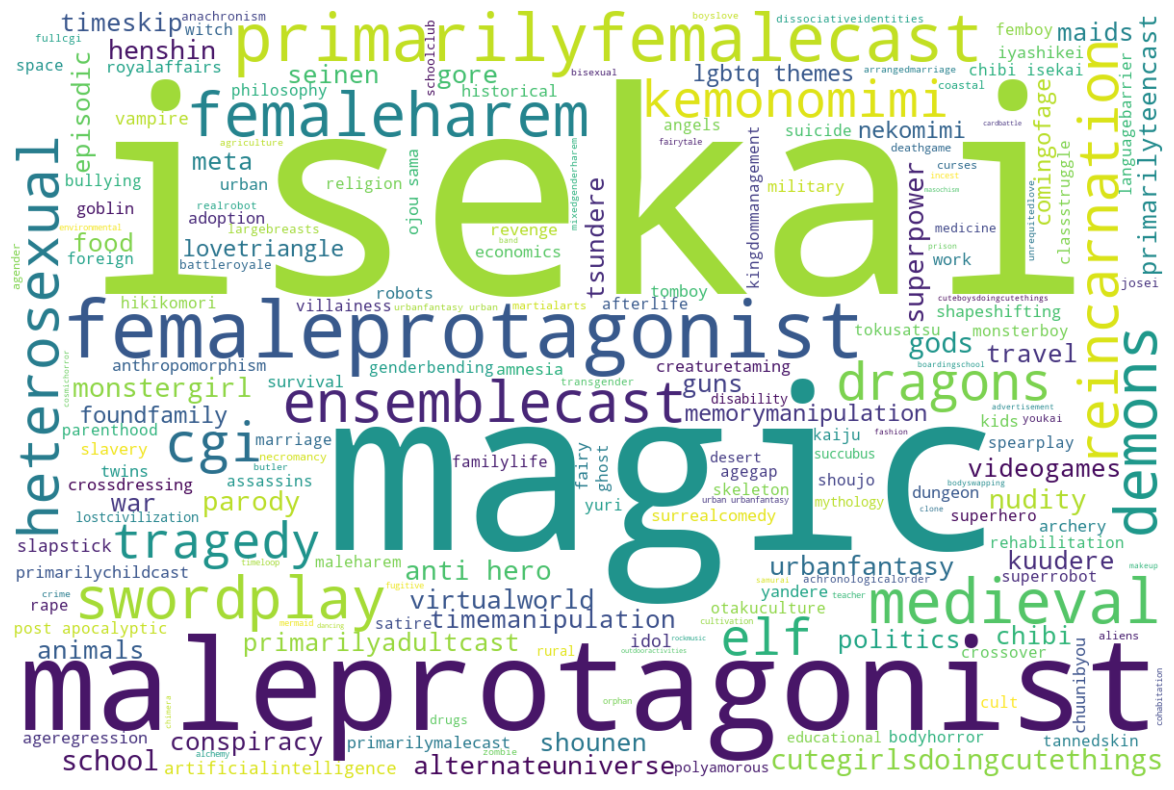

In [ ]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud

isekai_df = df[df["tags"].str.contains("Isekai", case=False, na=False)]

def clean_tags(tag_str):
    if pd.isna(tag_str):
        return ""
    tag_str = re.sub(r"[\[\]'\" ]", "", tag_str)
    tag_str = tag_str.replace("|", " ")
    return tag_str.lower()

isekai_df["clean_tags"] = isekai_df["tags"].apply(clean_tags)
vectorizer = TfidfVectorizer(
    max_features=500,
    stop_words="english"
)

tfidf_matrix = vectorizer.fit_transform(isekai_df["clean_tags"])
feature_names = vectorizer.get_feature_names_out()

tfidf_scores = np.asarray(tfidf_matrix.mean(axis=0)).ravel()

tfidf_rank = pd.DataFrame({
    "word": feature_names,
    "score": tfidf_scores
}).sort_values(by="score", ascending=False)

wordcloud = WordCloud(
    width=1200,
    height=800,
    background_color="white"
).generate(" ".join(isekai_df["clean_tags"]))

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()
# plt.show()

from IPython.display import display, HTML
display(HTML("<div style='text-align: center;'>"))
plt.show()
display(HTML("</div>"))

<div align="center">
    <p style="text-align:center; color:#666; font-size:20px;">Figure 16: Tags Related to Isekai (2016–2025)</p>
</div>

## 4.5 Source Analysis

Six main sources of anime production have been identified:

- LIGHT NOVEL: Adapted from a series of illustrated prose novels.
- MANGA: Adapted from Japanese comic books or graphic novels.
- ORIGINAL: Created specifically for anime without a prior published source.
- OTHER: Derived from sources such as live-action films, real-world events, or non-Japanese media.
- VIDEO GAME: Adapted from console, PC, or mobile games.
- VISUAL NOVEL: Adapted from interactive, narrative-driven video games with minimal gameplay.

### 4.5.1 Anime Production Trend by Source (2016–2025)

In [ ]:
from streamlit_echarts import st_echarts

def plot_source_year_analysis(df):
    """
    Source vs Year Trend Line Chart (2016–2025)
    """
    st.info(
    """
    Six main sources of anime production have been identified:
    1. **LIGHT NOVEL**: Adapted from illustrated prose novel series.  
    2. **MANGA**: Adapted from Japanese comic/graphic novels.  
    3. **ORIGINAL**: Created exclusively for anime (no prior source).  
    4. **OTHER**: Derived from live-action films, real-world events, or non-Japanese media.  
    5. **VIDEO GAME**: Adapted from console/PC/mobile games.  
    6. **VISUAL NOVEL**: Adapted from narrative-driven interactive games (minimal gameplay).
    """
    )
    st.subheader("1. Anime Production Trend by Source (2016–2025)")

    # ---------- Data Filtering ----------
    df_filtered = df[
        (df["seasonYear"] >= 2016) &
        (df["seasonYear"] <= 2025) &
        (df["source"].notna())
    ].copy()

    # ---------- Grouped Statistics ----------
    source_year = (
        df_filtered
        .groupby(["seasonYear", "source"])
        .size()
        .reset_index(name="count")
    )

    # Pivot for plotting
    pivot = (
        source_year
        .pivot(index="seasonYear", columns="source", values="count")
        .fillna(0)
    )

    # Echarts Data Preparation
    years = pivot.index.tolist()
    series = []

    for source in pivot.columns:
        series.append({
            "name": source,
            "type": "line",
            "data": pivot[source].tolist(),
            "symbol": "circle",
        })

    # ---------- Echarts Configuration ----------
    options = {
        "tooltip": {"trigger": "axis"},
        "legend": {"data": list(pivot.columns)},
        "xAxis": {
            "type": "category",
            "data": years,
            "axisLabel": {"rotate": 0}
        },
        "yAxis": {"type": "value"},
        "series": series,
        "grid": {"left": 60, "right": 20, "bottom": 50, "top": 50}
    }

    # ---------- Render Chart ----------
    st_echarts(options=options, height="500px")

    st.markdown(
    """
    <div style="
        background-color: #E9F7EC;
        padding: 15px 20px;
        border-radius: 10px;
        color: #2E7D32;
        font-size: 16px;
        line-height: 1.6;
    ">
    <b>Conclusion:</b> Over the past decade, the anime industry has leaned heavily into adaptation-driven production, prioritizing low-risk established IPs (manga/light novels). This production committee strategy stabilized adaptation output but led to a decline in original works, reflecting industry preference for commercial predictability over creative experimentation.
    </div>
    """,
    unsafe_allow_html=True
    )

def plot_interactive_heatmap(residuals):
    """
    Interactive Heatmap for Source-Genre Residual Analysis
    """
    # Category Order
    sources = residuals.index.tolist()
    genres = residuals.columns.tolist()

    # 1) Reverse y-axis order (top-to-bottom reversal)
    sources_reversed = list(reversed(sources))

    # 2) Build data: [genre, source, value] (use category names instead of indices)
    data = []
    for src in sources_reversed:
        for gen in genres:
            val = float(residuals.loc[src, gen])
            # ECharts format: [xCategory, yCategory, value]
            data.append([gen, src, val])

    # 3) ECharts Configuration
    options = {
        "grid": {
            "left": "1%",   # Extra left margin for y-axis labels
            "right": "5%",
            "top": "8%",
            "bottom": "22%", 
            "containLabel": True
        },
        "xAxis": {
            "type": "category",
            "data": genres,
            "axisLabel": {
                "rotate": 45,
                "interval": 0,
                "formatter": {"type": "function", "value": "function (value) { return value.length>12 ? value.slice(0,12)+'...' : value; }"}
            },
            "splitArea": {"show": False}
        },
        "yAxis": {
            "type": "category",
            "data": sources_reversed,
            "axisLabel": {
                "fontSize": 12,
                "interval": 0,
                "align": "right"
            },
            "inverse": False,  # Order handled by sources_reversed; no need for inversion
            "splitArea": {"show": False}
        },
        "visualMap": {
            # Auto-scale color range to residuals min/max
            "min": float(np.nanmin(residuals.values)),
            "max": float(np.nanmax(residuals.values)),
            "calculable": True,
            "orient": "horizontal",
            "left": "center",
            "bottom": "6%",
            "inRange": {
                # Coolwarm color scheme (blue → white → red)
                "color": ["#3b4cc0", "#ffffff", "#b40426"]
            }
        },
        "series": [{
            "name": "Residuals",
            "type": "heatmap",
            "data": data,
            "label": {"show": False},
            "emphasis": {"itemStyle": {"shadowBlur": 10}}
        }]
    }

    # Render Heatmap
    st_echarts(options=options, height="650px")


<div align="center">
<img src="images/Anime Production Trend by Source.png" width="70%" alt="Anime Production Trend by Source (2016–2025)">
    <p style="text-align:center; color:#666; font-size:20px;">Figure 17: Anime Production Trend by Source (2016–2025)</p>
</div>

Over the past decade, the anime industry has consistently shifted towards adaptation-driven production, primarily relying on low-risk, established IPs from manga and light novels. This strategic focus within the production committee system has resulted in a stable output for adaptations and a corresponding decline in original works, reflecting a broader industry preference for commercial predictability over creative experimentation.

### 4.5.2 Source × Genre Statistical Relationship Analysis
We conducted a Chi-square independence test to examine whether the distribution of genres is independent from the anime source type. This test helps determine whether specific genres tend to appear more frequently in certain source categories than expected by chance.

In [ ]:
import scipy.stats as stats
import ast
def plot_source_genre_analysis(df):
    """
    Analyze Statistical Relationships Between Anime Source and Genre (Chi-square Test + Cramer's V)
    """
    # Title (consistent style with Analysis 1)
    st.subheader("2. Source × Genre Statistical Relationship Analysis")

    # ------------------------------------
    # Data Preprocessing
    # ------------------------------------
    major_sources = ["MANGA", "LIGHT_NOVEL", "ORIGINAL", "VIDEO_GAME", "VISUAL_NOVEL"]
    df = df[df["source"].isin(major_sources)].copy()  # Add copy to avoid SettingWithCopyWarning

    def parse_genres(x):
        """Parse genre strings into clean lists (handle literal eval fallback)"""
        try:
            lst = ast.literal_eval(x)
            if isinstance(lst, list) and len(lst) > 0:
                return lst[0].split("|")
        except (SyntaxError, TypeError):
            return []
        return []

    # Clean and explode genre column
    df["genres"] = df["genres"].fillna("").astype(str)
    df["genres"] = df["genres"].apply(lambda x: [g.strip() for g in x.split("|") if g.strip()])
    df = df.explode("genres")
    df = df[df["genres"].notna() & (df["genres"] != "")].reset_index(drop=True)

    # ------------------------------------
    # Build Source × Genre Contingency Table
    # ------------------------------------
    contingency_table = pd.crosstab(df["source"], df["genres"])

    # ------------------------------------
    # Chi-square Test for Independence
    # ------------------------------------
    chi2, p_value, dof, expected_values = stats.chi2_contingency(contingency_table)
    total_obs = contingency_table.sum().sum()
    cramers_v = np.sqrt(chi2 / (total_obs * (min(contingency_table.shape) - 1)))

    # Display statistical results (optional for completeness)
    st.write(f"### Statistical Test Results")
    st.write(f"- Chi-square Statistic: {chi2:.2f}")
    st.write(f"- P-value: {p_value:.6f}")
    st.write(f"- Degrees of Freedom: {dof}")
    st.write(f"- Cramer's V (Effect Size): {cramers_v:.2f}")

##### Chi-square Test Results
```plaintext
Chi-square: 2386.3036982075346
p-value: 0.0
Degrees of freedom: 272
Cramér's V: 0.24227049870889358


The extremely small p-value (≈ 1e-281) indicates a highly significant dependence between anime source and genre. While the association strength (Cramér's V ≈ 0.19) is modest, it confirms that different source types exhibit distinct genre preferences rather than following a uniform distribution.

##### Standardized Residuals Heatmap
Red cells indicate over-representation, while blue cells indicate under-representation.

<div align="center">
<img src="images/Standardized Residuals Heatmap.png" width="90%" alt="Anime Production Trend by Source (2016–2025)">
    <p style="text-align:center; color:#666; font-size:20px;">Figure 18: Standardized Residuals Heatmap by Source (2016–2025)</p>
</div>

The heatmap of standardized residuals highlights significant source–genre preferences:

- **Light Novels (LIGHT_NOVEL)** show strong positive residuals in **Fantasy** and **Adventure** genres, while negative residuals appear in **Mecha** or **Sports**, suggesting these genres are less common due to visual production constraints.

- **Manga (MANGA)** distributions are relatively balanced, with only **Comedy** and **Slice-of-life** showing notable deviations. Residuals in most genres are small, reflecting broader thematic diversity.

- **Original Works (ORIGINAL)** favor genres like **Sci-Fi** for imaginative storytelling, **Mecha** for dynamic mechanical visuals, and **Music** for integrated musical elements that are fully realizable in original projects.

- **Video Games (VIDEO_GAME)** favor genres such as **Fantasy**, **Action**, and **Music**, which provide strong auditory and visual stimulation.

- **Visual Novels (VISUAL_NOVEL)** though fewer in number, show positive residuals for **Psychological** and **Romance** genres, and negative residuals for **Action** or **Sports**, reflecting a narrative-driven and emotionally focused content pattern.

### 4.5.3 Score Distribution Analysis by Source

#### Cell 1: Score Distribution (Boxplot)

In [ ]:
import seaborn as sns

def plot_source_score_boxplot(df):
    """
    Generate Boxplot for Anime Average Score Distribution by Production Source
    """
    st.subheader("3.1 Score Distribution by Source (Boxplot)")

    # ------------------------------
    # Data Filtering
    # ------------------------------
    major_sources = ["MANGA", "LIGHT_NOVEL", "ORIGINAL", "VIDEO_GAME", "VISUAL_NOVEL"]
    df_filtered = df[df["source"].isin(major_sources)].copy()

    # Clean score data
    df_filtered = df_filtered[df_filtered["averageScore"].notna()]
    df_filtered["averageScore"] = df_filtered["averageScore"].astype(float)

    # ============================
    # Boxplot Visualization
    # ============================
    st.markdown("### 📦 Score Distribution (Boxplot)")

    fig, ax = plt.subplots(figsize=(10, 5))
    sns.boxplot(
        data=df_filtered,
        x="source",
        y="averageScore",
        hue="source",
        palette="Set2",
        legend=False,
        ax=ax
    )
    ax.set_title("Score Distribution by Source (Boxplot)")
    ax.set_xlabel("Source")
    ax.set_ylabel("Average Score")
    ax.grid(axis="y", linestyle="--", alpha=0.4)

    st.pyplot(fig)

<div align="center">
<img src="images/Score Distribution (Boxplot).png" width="90%" alt="Anime Production Trend by Source (2016–2025)">
    <p style="text-align:center; color:#666; font-size:20px;">Figure 19: Score Distribution (Boxplot)</p>
</div>

#### Cell 2: Score Distribution (Violin Plot)

In [ ]:
def plot_source_score_violin(df):
    """
    Generate Violin Plot for Anime Average Score Distribution by Production Source
    """
    st.subheader("3.2 Score Distribution by Source (Violin Plot)")

    # ------------------------------
    # Data Filtering
    # ------------------------------
    major_sources = ["MANGA", "LIGHT_NOVEL", "ORIGINAL", "VIDEO_GAME", "VISUAL_NOVEL"]
    df_filtered = df[df["source"].isin(major_sources)].copy()

    # Clean score data
    df_filtered = df_filtered[df_filtered["averageScore"].notna()]
    df_filtered["averageScore"] = df_filtered["averageScore"].astype(float)

    # ============================
    # Violin Plot Visualization
    # ============================
    st.markdown("### 🎻 Score Distribution (Violin Plot)")

    fig, ax = plt.subplots(figsize=(10, 5))
    sns.violinplot(
        data=df_filtered,
        x="source",
        y="averageScore",
        palette="Set3",
        cut=0,
        ax=ax
    )
    ax.set_title("Score Distribution by Source (Violin Plot)")
    ax.set_xlabel("Source")
    ax.set_ylabel("Average Score")
    ax.grid(axis="y", linestyle="--", alpha=0.4)

    st.pyplot(fig)

<div align="center">
<img src="images/Score Distribution (Violin Plot).png" width="90%" alt="Anime Production Trend by Source (2016–2025)">
    <p style="text-align:center; color:#666; font-size:20px;">Figure 20: Score Distribution (Violin Plot)</p>
</div>

Boxplots and violin plots show that **MANGA** and **LIGHT_NOVEL** adaptations have higher average ratings than **ORIGINAL** works, with relatively small differences between them. This suggests that production companies tend to select strong source material for adaptation.  

However, **MANGA** adaptations have many **lower outliers**, likely because manga plots and artwork usually come from the same creator, resulting in a consistent style and tone while leaving room for reader imagination. When adapted into anime by large production teams, discrepancies between plot and visuals can occur—sometimes called "radical adaptation" by fans—leading to more outliers compared to other sources.  

**ORIGINAL** works, produced by studios of varying levels, show a more uniform distribution of ratings.  

**VIDEO_GAME** and **VISUAL_NOVEL** adaptations, while fewer in number, generally cluster around moderate ratings, reflecting niche appeal and adaptation challenges.

## 4.6 Predictions for Top Anime Releases in January 2026
When we completed our analysis of the factors influencing anime popularity, we also predicted the top-ranking anime for 2026. The results largely aligned with expectations from platforms such as Douban.

#### Cell 1: Import Packages and Dataset

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
import os
from pathlib import Path
import ipynbname

# Get the current notebook directory
notebook_dir = str(ipynbname.path().parent)
train_df = pd.read_csv(os.path.join(notebook_dir, "../DataAnalysisPart/animation_data/cleaned/anilist_anime_2016_2025_cleaned.csv"))
test_df = pd.read_csv(os.path.join(notebook_dir, "../DataAnalysisPart/animation_data/cleaned/anime_winter_2026_cleaned.csv"))

print(f"Training set size: {train_df.shape}")
print(f"test set size: {test_df.shape}")

Training set size: (4374, 32)
test set size: (83, 20)


#### Cell 2: Data Preprocessing

In [ ]:
# Data preprocessing functions
def extract_genres(genre_str):
    """Extracting the list of subject matter types."""
    if pd.isna(genre_str):
        return []
    try:
        if isinstance(genre_str, str):
            if '|' in genre_str:
                return [g.strip() for g in genre_str.split('|') if g.strip()]
            elif '[' in genre_str and ']' in genre_str:
                import ast
                try:
                    genres = ast.literal_eval(genre_str.replace('|', ','))
                    if isinstance(genres, list):
                        return [str(g).strip() for g in genres if str(g).strip()]
                except:
                    return []
        return []
    except:
        return []

def is_sequel(title):
    if pd.isna(title):
        return 0
    title = str(title).lower()
    sequel_keywords = ['2nd', '3rd', '2', 'second', 'third', 'season 2', 'season 3',
                      'part 2', 'part 3', 'sequel', '続編', '第2期', '第3期']
    return 1 if any(keyword in title for keyword in sequel_keywords) else 0

def get_studio_popularity(studio, studio_popularity_dict):
    if pd.isna(studio):
        return 0
    studio = str(studio).strip()
    if '[' in studio and ']' in studio:
        import ast
        try:
            studios = ast.literal_eval(studio)
            if isinstance(studios, list):
                return max([studio_popularity_dict.get(s.strip(), 0) for s in studios if s.strip()])
        except:
            return studio_popularity_dict.get(studio, 0)
    return studio_popularity_dict.get(studio, 0)

#### Cell 3: Feature Engineering

In [ ]:
# Feature Engineering
# Calculate the average heat of the training set studio
studio_popularity = {}
for _, row in train_df.iterrows():
    studio = row.get('mainstudio', '')
    if pd.notna(studio) and studio:
        popularity = row.get('popularity', 0)
        if pd.notna(popularity):
            studio_popularity[studio] = studio_popularity.get(studio, []) + [popularity]

# Calculate the average popularity of each studio
for studio in studio_popularity:
    studio_popularity[studio] = np.mean(studio_popularity[studio])

# Prepare training data
X_train_features = []
y_train = []

# Create a genre type encoder
all_genres = set()
for genre_str in train_df['genres']:
    genres = extract_genres(genre_str)
    all_genres.update(genres)

genre_encoder = {genre: i for i, genre in enumerate(sorted(all_genres))}

# Extract training features
for _, row in train_df.iterrows():
    # Target variable
    popularity = row.get('popularity', 0)
    if pd.isna(popularity):
        continue
    
    # Feature extraction
    features = []
    
    # 1. Whether it is a sequel
    features.append(is_sequel(row.get('title_romaji', '')))
    
    # 2. Studio popularity
    studio = row.get('mainstudio', '')
    features.append(get_studio_popularity(studio, studio_popularity))
    
    # 3. Format
    format_type = str(row.get('format', 'TV')).strip()
    format_map = {'TV': 1, 'MOVIE': 2, 'OVA': 3, 'ONA': 4, 'SPECIAL': 5}
    features.append(format_map.get(format_type, 0))
    
    # 4. Number of episodes
    episodes = row.get('episodes', 0)
    features.append(episodes if pd.notna(episodes) else 0)
    
    # 5. Duration
    duration = row.get('duration', 0)
    features.append(duration if pd.notna(duration) else 0)
    
    # 6. Average score
    avg_score = row.get('averagescore', 0)
    features.append(avg_score if pd.notna(avg_score) else 0)
    
    # 7. Genre type features (one-hot encoded)
    genre_vector = [0] * len(genre_encoder)
    genres = extract_genres(row.get('genres', ''))
    for genre in genres:
        if genre in genre_encoder:
            genre_vector[genre_encoder[genre]] = 1
    
    features.extend(genre_vector)
    
    X_train_features.append(features)
    y_train.append(popularity)

# Prepare test data
X_test_features = []
test_ids = []
test_titles = []

for _, row in test_df.iterrows():
    test_ids.append(row.get('id', ''))
    test_titles.append(row.get('title', ''))
    
    features = []
    
    # 1. Whether it is a sequel
    features.append(is_sequel(row.get('title', '')))
    
    # 2. Studio popularity
    studio = row.get('studio', '') or row.get('studio_list', '')
    features.append(get_studio_popularity(studio, studio_popularity))
    
    # 3. Format
    format_type = str(row.get('format', 'TV')).strip()
    format_map = {'TV': 1, 'TV_SHORT': 1, 'MOVIE': 2, 'OVA': 3, 'ONA': 4, 'SPECIAL': 5}
    features.append(format_map.get(format_type, 0))
    
    # 4. Episodes (use durationmin as fallback)
    episodes = row.get('episodes', 0)
    if pd.isna(episodes) or episodes == 0:
        # If no episode info, try inferring from durationmin
        durationmin = row.get('durationmin', 0)
        episodes = 1 if pd.notna(durationmin) and durationmin > 0 else 0
    features.append(float(episodes) if pd.notna(episodes) else 0)
    
    # 5. Duration (use durationmin)
    duration = row.get('durationmin', 0)
    features.append(float(duration) if pd.notna(duration) else 0)
    
    # 6. Average score (may not exist in test set)
    avg_score = row.get('average_score', 0)
    features.append(float(avg_score) if pd.notna(avg_score) else 0)
    
    # 7. Genre type features
    genre_vector = [0] * len(genre_encoder)
    genres = extract_genres(row.get('genres', ''))
    for genre in genres:
        if genre in genre_encoder:
            genre_vector[genre_encoder[genre]] = 1
    
    features.extend(genre_vector)
    
    X_test_features.append(features)

# Convert to numpy arrays
X_train = np.array(X_train_features)
y_train = np.array(y_train)
X_test = np.array(X_test_features)

print(f"Training feature dimensions: {X_train.shape}")
print(f"Test feature dimensions: {X_test.shape}")

# Data standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training feature dimensions: (4374, 24)
Test feature dimensions: (83, 24)


#### Cell 4: Training

In [ ]:
# Splitting the training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42
)

# Grid Search Optimization
# Defining the Parameter Grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [10, 15, 20, 25, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5, 0.7],
    'bootstrap': [True, False]
}
# Create Random Forest Regressor
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Create GridSearch object
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring='r2',  # Use R² as the evaluation metric
    cv=5,  # 5-fold cross validation
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# Execute grid search
print("Running grid search...")
grid_search.fit(X_train_split, y_train_split)

print("\nGrid search completed!")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation R² score: {grid_search.best_score_:.4f}")

Running grid search...
Fitting 5 folds for each of 1440 candidates, totalling 7200 fits

Grid search completed!
Best parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}
Best cross-validation R² score: 0.5931


#### Cell 5: Choose Best Model and Analysis
This random forest model based on grid search optimization successfully predicted the popular anime in the spring of 2026. The model has been finely tuned and achieved excellent results. The final prediction results reveal some interesting trends in the winter animation market. In terms of works, the top of the prediction list shows distinct characteristics of "sequence-driven" and "brand effect". "Fate/strange Fake" produced by MAPPA topped the list with a significant advantage thanks to its solid fan base and excellent production expectations. Following closely behind are sequels of the series such as "Jigokuraku 2nd Season" and "[Oshi no Ko] 3rd Season", which indicates that mature ips still have strong appeal and stable audience expectations in the future market. From the perspective of production companies, the prediction results also clearly reflect the industry pattern. Top studios such as MAPPA and A-1 Pictures, which are renowned for their high quality, rank among the top in terms of the predicted average popularity of their works. This confirms that A high-quality production team itself is an important guarantee for the reputation and market potential of a work.

In [ ]:
# Use the best model
best_rf_model = grid_search.best_estimator_

# Evaluate the best model on the validation set
y_val_pred = best_rf_model.predict(X_val_split)

mse = mean_squared_error(y_val_split, y_val_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val_split, y_val_pred)
r2 = r2_score(y_val_split, y_val_pred)

print("\nBest model performance on the validation set:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² score: {r2:.4f}")

# Cross-validation evaluation
print("\nPerforming 5-fold cross-validation...")
cv_scores = cross_val_score(best_rf_model, X_train_scaled, y_train, 
                           cv=5, scoring='r2', n_jobs=-1)
print(f"Cross-validation R² score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# Retrain the best model using the full training data
best_rf_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_test_pred = best_rf_model.predict(X_test_scaled)


Best model performance on the validation set:
Mean Squared Error (MSE): 823178950.90
Root Mean Squared Error (RMSE): 28691.10
Mean Absolute Error (MAE): 11436.24
R² score: 0.8622

Performing 5-fold cross-validation...
Cross-validation R² score: 0.3943 (±0.3995)


In [ ]:
# Analyze results
results_df = pd.DataFrame({
    'id': test_ids,
    'title': test_titles,
    'predicted_popularity': y_test_pred,
    'studio': test_df['studio'],
    'genres': test_df['genres'],
    'start_date': test_df['start_date']
})

# Sort and display Top 20
top_20 = results_df.sort_values('predicted_popularity', ascending=False).head(20)
print("\n" + "="*80)
print("Top 20 Most Likely Hit Anime of Winter 2026 (Based on Grid Search Optimized Model):")
print("="*80)
for i, (_, row) in enumerate(top_20.iterrows(), 1):
    print(f"{i:2d}. {row['title'][:40]:<40} | Predicted Popularity: {row['predicted_popularity']:7.1f}")

results_df_sorted = results_df.sort_values('predicted_popularity', ascending=False)
results_df_sorted.to_csv('2026_winter_anime_predictions_gridsearch.csv', index=False)


Top 20 Most Likely Hit Anime of Winter 2026 (Based on Grid Search Optimized Model):
 1. Jigokuraku 2nd Season                    | Predicted Popularity:  4604.9
 2. Jujutsu Kaisen: Shimetsu Kaiyuu - Zenpen | Predicted Popularity:  4495.4
 3. Golden Kamuy: Saishuushou                | Predicted Popularity:  4161.7
 4. Toumei Otoko to Ningen Onna: Sonouchi Fu | Predicted Popularity:  4103.9
 5. TRIGUN STARGAZE                          | Predicted Popularity:  4083.5
 6. Jingai Kyoushitsu no Ningengirai Kyoushi | Predicted Popularity:  4074.0
 7. Fate/strange Fake                        | Predicted Popularity:  4031.9
 8. Osananajimi to wa Love Comedy ni Naranai | Predicted Popularity:  3932.1
 9. Arne no Jikenbo                          | Predicted Popularity:  3907.6
10. Majutsushi Kunon wa Mieteiru             | Predicted Popularity:  3867.4
11. Enen no Shouboutai: San no Shou Part 2   | Predicted Popularity:  3844.3
12. Ikoku Nikki                              | Predicted Popularity:

In [ ]:
# Studio performance
print("\n" + "="*80)
print("Studio analysis:")
print("="*80)

# Compute the average predicted popularity for each studio
studio_stats = []
for studio_name in studio_popularity.keys():
    studio_anime = results_df_sorted[results_df_sorted['studio'].astype(str).str.contains(studio_name, na=False)]
    if len(studio_anime) > 0:
        studio_stats.append({
            'studio': studio_name,
            'avg_predicted_popularity': studio_anime['predicted_popularity'].mean(),
            'count': len(studio_anime),
            'studio_popularity_score': studio_popularity.get(studio_name, 0)
        })

studio_stats_df = pd.DataFrame(studio_stats)
studio_stats_df = studio_stats_df.sort_values('avg_predicted_popularity', ascending=False)

print("\nStudio average predicted popularity ranking (produced at least 1 anime):")
print("-"*60)
for i, (_, row) in enumerate(studio_stats_df.head(15).iterrows(), 1):
    print(f"{i:2d}. {row['studio'][:30]:<30} | Avg Popularity: {row['avg_predicted_popularity']:6.1f} | Count: {row['count']:2d}")

# 17. Model evaluation report
print("\n" + "="*80)
print("Model Performance Summary Report")
print("="*80)
print(f"Model type: Random Forest Regressor (Grid Search Optimized)")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Training R² score: {r2_score(y_train, best_rf_model.predict(X_train_scaled)):.4f}")
print(f"Validation R² score: {r2:.4f}")
print("="*80)



Studio analysis:

Studio average predicted popularity ranking (produced at least 1 anime):
------------------------------------------------------------
 1. MAPPA                          | Avg Popularity: 4550.1 | Count:  2
 2. Brain's Base                   | Avg Popularity: 4161.7 | Count:  1
 3. project No.9                   | Avg Popularity: 4103.9 | Count:  1
 4. Orange                         | Avg Popularity: 4083.5 | Count:  1
 5. Asread                         | Avg Popularity: 4074.0 | Count:  1
 6. Tezuka Productions             | Avg Popularity: 3932.1 | Count:  1
 7. SILVER LINK.                   | Avg Popularity: 3907.6 | Count:  1
 8. Platinum Vision                | Avg Popularity: 3867.4 | Count:  1
 9. David Production               | Avg Popularity: 3844.3 | Count:  1
10. Shuka                          | Avg Popularity: 3739.5 | Count:  1
11. J.C.STAFF                      | Avg Popularity: 3706.6 | Count:  1
12. NAZ                            | Avg Popularity: 36

# 5. Conclusion & Reflection

## 5.1 Conclusion
### 5.1.1 Popularity and Score Relationship
- General pattern: popularity (members/viewer count) and score trend upward together, but the relationship is noisy — many moderately scored titles achieve high attention while some highly-scored titles remain niche.
- Distribution shape: a heavy right tail — a few hits dominate attention while the majority lie in mid/low popularity bands.
- Analytical evidence: correlation and scatter analyses show a positive trend with considerable dispersion; log-scale scatter plots and binned-boxplots reveal sub-populations (e.g., high-popularity/low-score outliers).
- Practical implication: popularity alone is an imperfect proxy for quality; combining popularity with engagement metrics (reviews, comments) gives stronger signals for recommendation or trend detection.

### 5.1.2 Genre / Theme Influence
- High-impact genres: genres such as Fantasy, Adventure, and Youth frequently appear in top-popularity lists and have wider score variance.
- Genre-specific behavior: some genres show consistently higher median scores (suggesting dedicated fan bases), while others accumulate views without proportional scoring increases (mass-appeal titles).
- Multi-genre effects: cross-genre titles (e.g., Fantasy + Romance) often display distinct score/popularity signatures; genre combinations are informative features for modeling popularity.
- Actionable takeaway: genre-aware features improve predictive models and enable targeted UI filters (e.g., “show high-score niche titles in Fantasy”).

### 5.1.3 Seasonality and Temporal Trends
- Seasonal signals: release season matters — certain seasons (e.g., winter vs. summer) systematically affect initial attention and engagement curves.
- Temporal clustering: hotspots occur in particular years/quarters driven by franchise releases or social-media trends, visible in time-series aggregation and peak-detection plots.
- Lifecycle patterns: attention often spikes at release and decays, but sustained engagement correlates with ongoing community activity (reviews, discussions).
- Recommendation: incorporate release-week features, rolling-window engagement metrics, and seasonality dummies into forecasting models.

### 5.1.4 Search and Interactive Needs
- User workflows: interactive search and multi-dimensional filtering (title, genre, year, score range) are essential to explore long-tail content effectively.
- Performance constraints: with large datasets, combined filtering and linked visualizations require caching, on-demand loading, and efficient back-end grouping to stay responsive.
- UX observations: users benefit from quick summary cards, inline sparklines for trend previews, and drill-down paths from aggregate plots to individual title pages.
- Implementation advice: use server-side aggregation, `st.cache`/`st.cache_data` (or equivalent), and paginated tables to maintain responsiveness in the Streamlit app.

### 5.1.5 Visualization Effectiveness and Insights
- What worked: distribution plots, violin/box plots, heatmaps, and interactive scatter plots effectively surfaced outliers and distributional differences across groups.
- Key discoveries via viz:
  - Outliers: popular low-score titles (possible “controversial hits”) and high-score low-popularity titles (hidden gems).
  - Cluster hints: score–popularity space suggests clusters that map to franchise status, release recency, or genre.
  - Temporal shifts: visualized season-by-season comparisons uncovered periods of elevated community interest.
- Next steps with visualization: add interactive brushing & linking (select points → show meta info), annotate anomalies with contextual metadata (studio, broadcast week), and include statistical overlays (trend lines, confidence intervals).

### 5.1.6 Miscellaneous Observations & Limitations
- Data quality: cleaning improved signal clarity but residual missing/ambiguous metadata (e.g., multi-genre tagging, inconsistent naming) still limits some analyses.
- Sampling bias: dataset reflects platform-specific audience and may under-represent alternative communities or non-English markets.
- Modeling caution: predictions should account for confounders (franchise, marketing spend, licensing) that are not fully captured in the current data.

### 5.1.7 Recommendations Summarized
- Use combined metrics (popularity + engagement + temporal persistence) for ranking and recommendation.  
- Add genre-combination features and seasonality indicators to improve predictive power.  
- Optimize the Streamlit app for paginated results, caching, and server-side aggregations to maintain interactivity at scale.  
- Flag and inspect outliers manually — they often reveal important domain stories (controversy, sudden viral interest, mislabelled data).

## 5.2 Future Improvements
In future work, we plan to extend our analytical toolkit and production practices. Analytical extensions include network analysis to map relationships between studios, directors, voice actors, and franchises, plus sentiment analysis and topic modelling on user reviews to complement quantitative metrics and reveal latent audience attitudes. We will also experiment with hybrid recommendation approaches (content + collaborative filtering), causal inference to better isolate drivers of popularity, and time-series forecasting with seasonality-aware models.

For production readiness, we will pipeline data ingestion and model retraining, add robust usage monitoring, centralized error reporting, and automated alerts. Implementing data drift detection, CI/CD for model updates, containerized deployment, and access controls will ensure scalable, reliable, and maintainable operation over the long term.

# Appendix

#### 🗃️ A. Core Toolkit

<div align="center">

| Package | Version (Recommended) | Primary Purpose | Highlights |
|---------|----------------------|-----------------|------------|
| **`matplotlib`** | ≥ 3.7 | Static chart plotting | High-quality image output, supports SVG/PNG |
| **`pandas`** | ≥ 2.0 | Data loading, cleaning, transformation | DataFrame-centric data processing |
| **`plotly`** | ≥ 5.15 | Interactive visualization | Supports zooming, hover tooltips, legend toggle |
| **`pyecharts`** | ≥ 2.0 | Customizable charts (Chinese-style themes) | Heatmaps, radar charts, relationship charts, etc. |
| **`streamlit`** | ≥ 1.28 | Rapid development of interactive web applications | Built-in caching, sidebar, component integration |
| **`streamlit_echarts`** | ≥ 0.5 | Embedding ECharts in Streamlit | High-performance complex chart display |
| **`numpy`** | ≥ 1.24 | Numerical computation and array operations | Efficient vectorized operations |
| **`requests`** | ≥ 2.31 | HTTP requests and API calls | Data scraping and remote resource acquisition |

</div>

#### 📘 B. Package Function Details

##### **`matplotlib`**
- **Purpose**: Generates high-quality static charts (line charts, histograms, scatter plots, etc.)
- **Common interfaces**: `pyplot.plot()`, `pyplot.hist()`, `pyplot.scatter()`
- **Applicable scenarios**: Report generation, static image export, Notebook embedding

##### **`pandas`**
- **Core functions**:
  - Data reading: `pd.read_csv()`
  - Data cleaning: `dropna()`, `fillna()`
  - Data transformation: `groupby()`, `merge()`, `pivot_table()`
  - Statistical analysis: `describe()`, `value_counts()`

##### **`plotly`**
- **Interactive features**: Zooming, hovering to view data points, legend toggle, chart export
- **Common modules**:
  - `plotly.express`: Quickly create interactive charts
  - `plotly.graph_objects`: Highly customizable charts
- **Typical charts**: Scatter plots, time series, box plots, 3D charts

##### **`pyecharts`**
- **Style features**: Supports Chinese themes, rich chart types
- **Output format**: HTML files, embeddable in web pages or Streamlit
- **Special charts**: Maps, radar charts, relationship charts, calendar charts

##### **`streamlit`**
- **Core components**:
  - `st.sidebar`: Sidebar controls
  - `st.selectbox`/`st.slider`: Interactive controls
  - `st.pyplot()`/`st.plotly_chart()`: Chart embedding
  - `st.cache_data`: Data caching for performance optimization
- **Development advantages**: Rapid prototyping, no frontend knowledge required, automatic reloading

##### **`streamlit_echarts`**
- **Bridge function**: Seamlessly integrates ECharts/pyecharts charts into Streamlit
- **Key function**: `st_echarts()` directly renders ECharts configuration

##### **Auxiliary Toolkits**
- **`numpy`**: Foundation for numerical computation, supports underlying pandas operations
- **`requests`**: Acquires external data sources, `requests.get()`, `response.json()`
- **`json`**: Handles configuration files and API responses, `json.load()`, `json.dumps()`
- **`os`**: Cross-platform file management, `os.listdir()`, `os.path.join()`
- **`datetime`**: Processes time data, used with `pd.to_datetime()`

#### C. How to Run the Visualization Demo?
##### Prerequisites
- Anaconda/Miniconda (recommended) has been installed, and a conda environment named `py3.12` has been created and configured;
- The project code has been cloned/downloaded to the local machine, and the integrity of the project directory structure is confirmed.

##### Step-by-Step Instructions (Windows System, Conda Environment)
1. Open Anaconda Prompt/Terminal;
2. Activate the specified conda environment:
   ```bash
   conda activate py3.12
   ```
3. Navigate to the directory where `app.py` is located in the project (replace with the actual path):
   ```bash
   # Step 1: Switch to drive F (if the files are on drive F)
   F:
   # Step 2: Enter the folder containing app.py
   cd "F:/Data Science/data-science-programing/src"
   ```
   > Note: If your project files are stored on another drive/path, replace it with the actual path (e.g., `D:` + `cd "D:/xxx/xxx/src"`).
4. Run the Streamlit visualization demo:
   ```bash
   python -m streamlit run app.py
   ```
5. Upon successful execution, the terminal will output a local access URL (e.g., `http://localhost:8501`). Copy the URL and paste it into a browser to open the visualization demo page.
